# **Setting**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu, chi2_contingency
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, silhouette_score
import shap
import gower
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [ ]:
Path.cwd()

PosixPath('/home/nakyung/projects/vitaldb_ecg_arrhythmia/notebooks')

In [ ]:
os.chdir("..")

In [ ]:
# 1) 경로 설정
CASES_PATH = "data/raw/cases.csv"  

# 2) 데이터 로드
df_cases = pd.read_csv(CASES_PATH)
print(df_cases.shape)
df_cases.head()

(6388, 74)


caseid  subjectid  casestart  caseend  anestart   aneend  opstart  opend  \
0       1       5955          0    11542      -552  10848.0     1668  10368   
1       2       2487          0    15741     -1039  14921.0     1721  14621   
2       3       2861          0     4394      -590   4210.0     1090   3010   
3       4       1903          0    20990      -778  20222.0     2522  17822   
4       5       4416          0    21531     -1009  22391.0     2591  20291   

      adm      dis  ...  intraop_colloid  intraop_ppf  intraop_mdz  \
0 -236220   627780  ...                0          120          0.0   
1 -221160  1506840  ...                0          150          0.0   
2 -218640    40560  ...                0            0          0.0   
3 -201120   576480  ...                0           80          0.0   
4  -67560  3734040  ...                0            0          0.0   

  intraop_ftn  intraop_rocu  intraop_vecu  intraop_eph  intraop_phe  \
0         100            70             0           10            0   
1           0           100             0           20            0   
2           0            50             0            0            0   
3         100           100             0           50            0   
4           0           160             0           10          900   

   intraop_epi intraop_ca  
0            0          0  
1            0          0  
2            0          0  
3            0          0  
4            0       2100  

[5 rows x 74 columns]

---

# **1.Overall Exploratory Data Analysis**

In [98]:
# 색상
MAIN_COLOR = "#4a90e2"
ACCENT_COLOR = "#e94e77"

# sex 정제
cases['sex'] = cases['sex'].astype(str).str.strip()
cases['sex_label'] = cases['sex'].map({'M':'Male','F':'Female'})

# 시간 파생 변수
cases['anesthesia_duration'] = cases['aneend'] - cases['anestart']
cases['surgery_duration'] = cases['opend'] - cases['opstart']
cases['case_duration'] = cases['caseend'] - cases['casestart']
cases['ane_to_op_delay'] = cases['opstart'] - cases['anestart']

### 1. DataSet Overview

In [96]:
cases = df_cases

In [97]:
cases.shape

(6388, 74)

In [99]:
cases.isnull().sum()

caseid                    0
subjectid                 0
casestart                 0
caseend                   0
anestart                  0
aneend                    0
opstart                   0
opend                     0
adm                       0
dis                       0
icu_days                  0
death_inhosp              0
age                       0
sex                       0
height                    0
weight                    0
bmi                       0
asa                     133
emop                      0
department                0
optype                    0
dx                        0
opname                    0
approach                  0
position                194
ane_type                  0
preop_htn                 0
preop_dm                  0
preop_ecg                 0
preop_pft                 0
preop_hb                341
preop_plt               341
preop_pt                390
preop_aptt              402
preop_na                623
preop_k             

In [100]:
cases.describe(include="all").T

count unique                   top  freq           mean  \
caseid               6388.0    NaN                   NaN   NaN         3194.5   
subjectid            6388.0    NaN                   NaN   NaN    3047.726362   
casestart            6388.0    NaN                   NaN   NaN            0.0   
caseend              6388.0    NaN                   NaN   NaN   11348.680651   
anestart             6388.0    NaN                   NaN   NaN    -757.002974   
aneend               6388.0    NaN                   NaN   NaN -566655.850814   
opstart              6388.0    NaN                   NaN   NaN    2188.399029   
opend                6388.0    NaN                   NaN   NaN   10347.526769   
adm                  6388.0    NaN                   NaN   NaN -854325.540232   
dis                  6388.0    NaN                   NaN   NaN    50507.52176   
icu_days             6388.0    NaN                   NaN   NaN       0.552755   
death_inhosp         6388.0    NaN                   NaN   NaN       0.008923   
age                  6388.0    NaN                   NaN   NaN      57.296493   
sex                    6388      2                     M  3243            NaN   
height               6388.0    NaN                   NaN   NaN     162.188832   
weight               6388.0    NaN                   NaN   NaN      61.484922   
bmi                  6388.0    NaN                   NaN   NaN      23.278522   
asa                  6255.0    NaN                   NaN   NaN        1.84956   
emop                 6388.0    NaN                   NaN   NaN       0.122417   
department             6388      4       General surgery  4930            NaN   
optype                 6388     11            Colorectal  1350            NaN   
dx                     6388   1038  Early gastric cancer   252            NaN   
opname                 6388    241       Cholecystectomy   503            NaN   
approach               6388      3                  Open  3365            NaN   
position               6194     10                Supine  3883            NaN   
ane_type               6388      3               General  6043            NaN   
preop_htn            6388.0    NaN                   NaN   NaN       0.307608   
preop_dm             6388.0    NaN                   NaN   NaN       0.103475   
preop_ecg              6388     27   Normal Sinus Rhythm  6306            NaN   
preop_pft              6388      9                Normal  5348            NaN   
preop_hb             6047.0    NaN                   NaN   NaN       12.83319   
preop_plt            6047.0    NaN                   NaN   NaN     241.437738   
preop_pt             5998.0    NaN                   NaN   NaN      100.43998   
preop_aptt           5986.0    NaN                   NaN   NaN      32.884146   
preop_na             5765.0    NaN                   NaN   NaN     140.026366   
preop_k              5767.0    NaN                   NaN   NaN       4.196411   
preop_gluc           6010.0    NaN                   NaN   NaN     115.644759   
preop_alb            6016.0    NaN                   NaN   NaN        4.06378   
preop_ast            6022.0    NaN                   NaN   NaN      32.436068   
preop_alt            6024.0    NaN                   NaN   NaN      30.276062   
preop_bun            6023.0    NaN                   NaN   NaN      16.160883   
preop_cr             6016.0    NaN                   NaN   NaN       1.080918   
preop_ph              546.0    NaN                   NaN   NaN       7.389562   
preop_hco3            533.0    NaN                   NaN   NaN      24.073546   
preop_be              532.0    NaN                   NaN   NaN      -0.384962   
preop_pao2            538.0    NaN                   NaN   NaN     102.434572   
preop_paco2           538.0    NaN                   NaN   NaN      39.890706   
preop_sao2            533.0    NaN                   NaN   NaN      92.589869   
cormack                5553      5                   

### 2. Patient Characteristics

2.1 Age Distribution

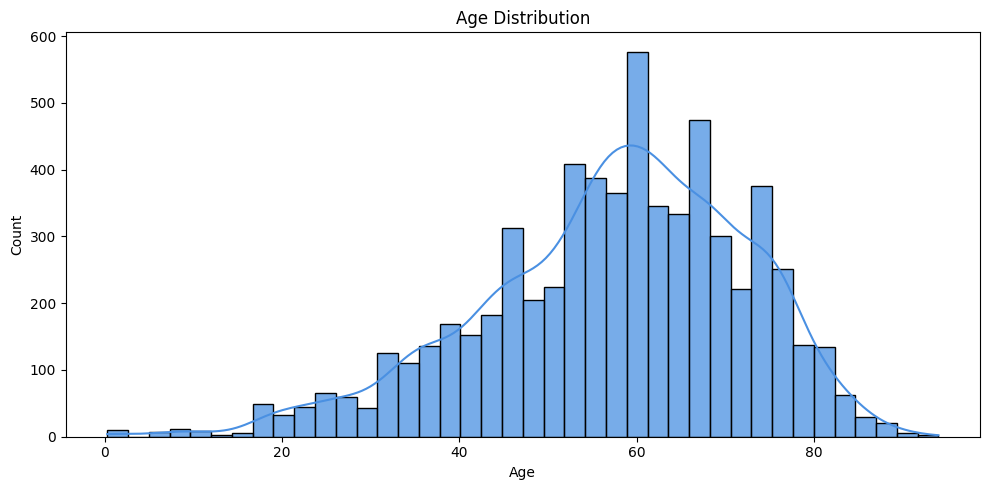

In [101]:
plt.figure(figsize=(10,5))
sns.histplot(cases['age'], bins=40, kde=True, color=MAIN_COLOR, alpha=.75)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.tight_layout()
plt.show()

In [102]:
# summary statistics
mean_age = cases['age'].mean()
median_age = cases['age'].median()
mean_age, median_age

(np.float64(57.2964934251722), np.float64(59.0))

In [104]:
bins = [0, 40, 60, 80, 120]
labels = ['<40', '40-60', '60-80', '80+']
cases['age_group'] = pd.cut(cases['age'], bins=bins, labels=labels, include_lowest=True)

In [105]:
age_group_ratio = (cases['age_group'].value_counts(normalize=True) * 100).sort_index()
age_group_ratio

age_group
<40      13.775830
40-60    40.936130
60-80    42.031935
80+       3.256105
Name: proportion, dtype: float64

/tmp/ipykernel_3605200/3956768411.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


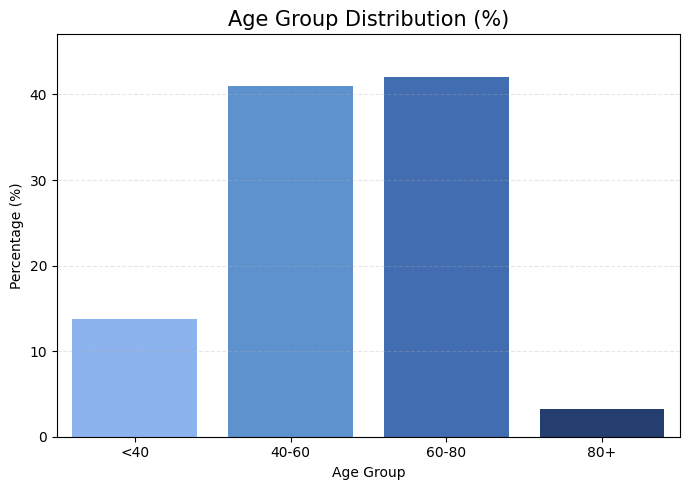

In [106]:
plt.figure(figsize=(7,5))
sns.barplot(
    x=age_group_ratio.index,
    y=age_group_ratio.values,
    palette=["#7dafff", "#4a90e2", "#2f69c3", "#163a7c"]
)
plt.title("Age Group Distribution (%)", fontsize=15)
plt.xlabel("Age Group")
plt.ylabel("Percentage (%)")
plt.ylim(0, max(age_group_ratio.values) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

2.2 Sex Distribution

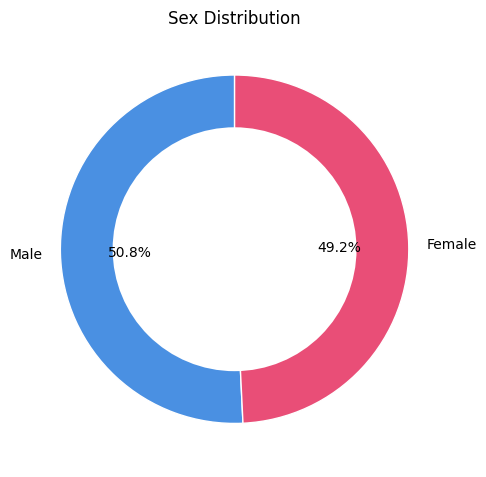

In [107]:
counts = cases['sex_label'].value_counts()

fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=[MAIN_COLOR, ACCENT_COLOR],
    wedgeprops={'edgecolor':'white'}
)

centre = plt.Circle((0,0),0.7,fc='white')
fig.gca().add_artist(centre)

plt.title("Sex Distribution")
plt.tight_layout()
plt.show()

In [108]:
# summary
sex_counts = cases['sex_label'].value_counts()
sex_ratio = cases['sex_label'].value_counts(normalize=True)*100
sex_counts, sex_ratio

(sex_label
 Male      3243
 Female    3145
 Name: count, dtype: int64,
 sex_label
 Male      50.767063
 Female    49.232937
 Name: proportion, dtype: float64)

2.3 BMI Distribution

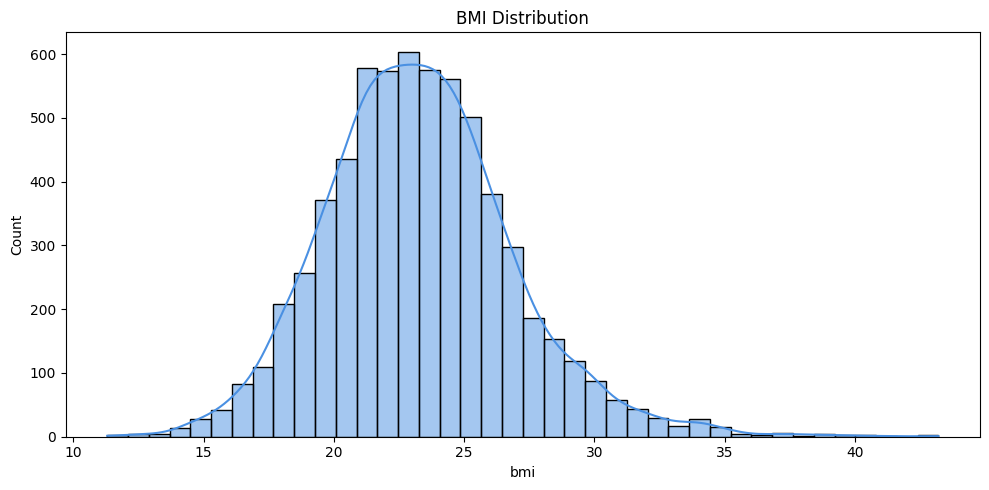

In [109]:
plt.figure(figsize=(10,5))
sns.histplot(cases['bmi'], bins=40, kde=True, color=MAIN_COLOR)
plt.title("BMI Distribution")
plt.tight_layout()
plt.show()

In [110]:
# BMI summary stats
bmi_desc = cases['bmi'].describe()

# Obesity ratio
obese_ratio = (cases['bmi'] >= 30).mean() * 100

# Combine into one table
bmi_table = pd.DataFrame({
    "BMI Stats": bmi_desc,
})

bmi_table.loc["obesity(>=30%)"] = obese_ratio

bmi_table

BMI Stats
count           6388.000000
mean              23.278522
std                3.623655
min               11.300000
25%               20.900000
50%               23.100000
75%               25.400000
max               43.200000
obesity(>=30%)     4.085786

2.4 ASA Classification

/tmp/ipykernel_3605200/3934829157.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='asa', data=cases, palette="Blues")


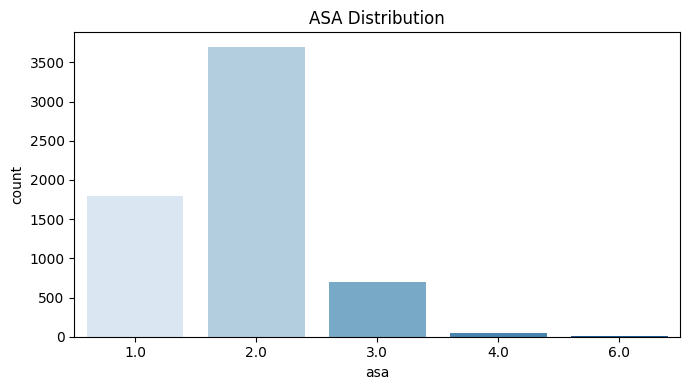

In [111]:
plt.figure(figsize=(7,4))
sns.countplot(x='asa', data=cases, palette="Blues")
plt.title("ASA Distribution")
plt.tight_layout()
plt.show()

In [112]:
# summary
high_risk_ratio = (cases['asa'] >= 3).mean()*100
cases['asa'].value_counts(), high_risk_ratio

(asa
 2.0    3699
 1.0    1792
 3.0     703
 4.0      48
 6.0      13
 Name: count, dtype: int64,
 np.float64(11.959924859110833))

2.5 Emergency Surgery (emop)

In [ ]:
emop_ratio = cases['emop'].mean()*100
emop_ratio

np.float64(12.241703193487789)

In [114]:
# emop vs mortality
pd.crosstab(cases['emop'], cases['death_inhosp'], normalize='index')*100

death_inhosp          0         1
emop                             
0             99.500535  0.499465
1             96.291560  3.708440

2.6 Preoperative Comorbidity (DM, HTN)

In [115]:
dm_rate = cases['preop_dm'].mean()*100
htn_rate = cases['preop_htn'].mean()*100
dm_rate, htn_rate

(np.float64(10.347526612398248), np.float64(30.76080150281778))

/tmp/ipykernel_3605200/2336605905.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


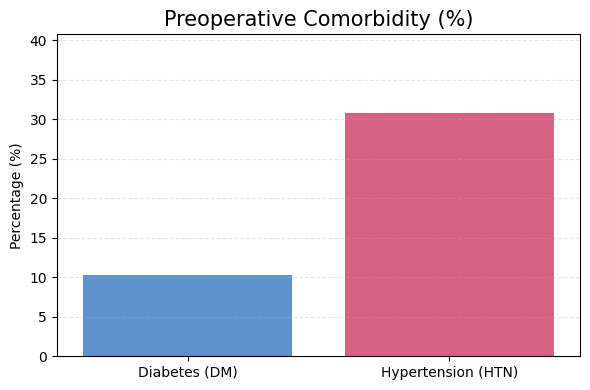

In [116]:
comorbidity_labels = ['Diabetes (DM)', 'Hypertension (HTN)']
comorbidity_values = [dm_rate, htn_rate]

plt.figure(figsize=(6,4))
sns.barplot(
    x=comorbidity_labels,
    y=comorbidity_values,
    palette=["#4a90e2", "#e94e77"]
)
plt.title("Preoperative Comorbidity (%)", fontsize=15)
plt.ylabel("Percentage (%)")
plt.ylim(0, max(comorbidity_values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

2.7 Preoperative ECG & Lab (Hb, K, Na)

In [117]:
cases[['preop_hb','preop_k','preop_na','preop_ecg']].describe()

preop_hb      preop_k     preop_na
count  6047.00000  5767.000000  5765.000000
mean     12.83319     4.196411   140.026366
std       1.98949     0.408209     2.895233
min       3.50000     2.500000   111.000000
25%      11.60000     3.900000   139.000000
50%      13.00000     4.200000   140.000000
75%      14.20000     4.400000   142.000000
max      20.20000     8.400000   150.000000

In [118]:
abnormal_k = ((cases['preop_k']<3.5)|(cases['preop_k']>5)).mean()*100
anemia_rate = (cases['preop_hb']<12).mean()*100
abnormal_k, anemia_rate

(np.float64(4.727614276768942), np.float64(28.036944270507203))

2.8 Age vs ASA Analysis

/tmp/ipykernel_3605200/2764355459.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


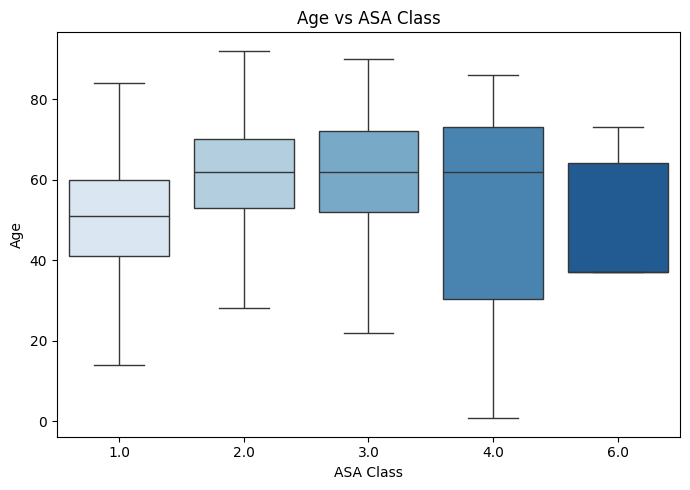

In [119]:
# Age vs ASA Boxplot
plt.figure(figsize=(7,5))
sns.boxplot(
    x='asa',
    y='age',
    data=cases,
    palette="Blues",
    showfliers=False
)
plt.title("Age vs ASA Class")
plt.xlabel("ASA Class")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

In [120]:
# Age Group × ASA Cross-table
pd.crosstab(
    cases['age_group'],
    cases['asa'],
    normalize='index'
) * 100

asa              1.0        2.0        3.0       4.0       6.0
age_group                                                     
<40        50.467290  35.981308  10.981308  1.518692  1.051402
40-60      36.494926  54.410617   8.743169  0.351288  0.000000
60-80      15.743551  70.485584  12.822458  0.796662  0.151745
80+         4.975124  69.154229  23.383085  2.487562  0.000000

In [121]:
# Age–ASA 상관계수
cases[['age','asa']].corr(method='spearman')

age       asa
age  1.000000  0.282659
asa  0.282659  1.000000

### 3. Surgery Characteristics

3.1 Anesthesia Duration (hrs)

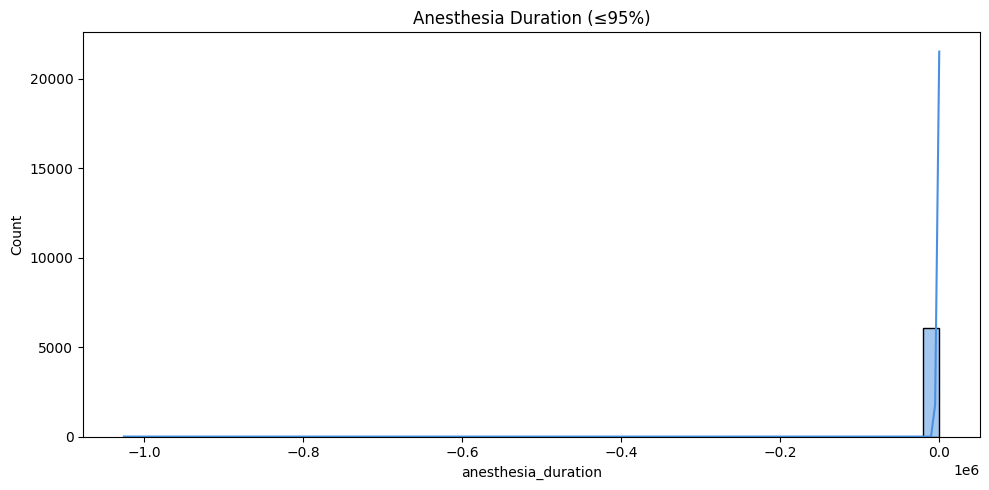

In [122]:
q95 = cases['anesthesia_duration'].quantile(.95)
plt.figure(figsize=(10,5))
sns.histplot(cases[cases['anesthesia_duration']<q95]['anesthesia_duration']/3600,
             bins=50, kde=True, color=MAIN_COLOR)
plt.title("Anesthesia Duration (≤95%)")
plt.tight_layout()
plt.show()

In [123]:
# IQR
an_hr = cases['anesthesia_duration']/3600
Q1 = an_hr.quantile(.25)
Q2 = an_hr.quantile(.50)
Q3 = an_hr.quantile(.75)
IQR = Q3 - Q1
Q1, Q2, Q3, IQR

(np.float64(1.8666666665972222),
 np.float64(2.9166666666666665),
 np.float64(4.333333333333333),
 np.float64(2.466666666736111))

3.2 Surgery Duration (hrs)

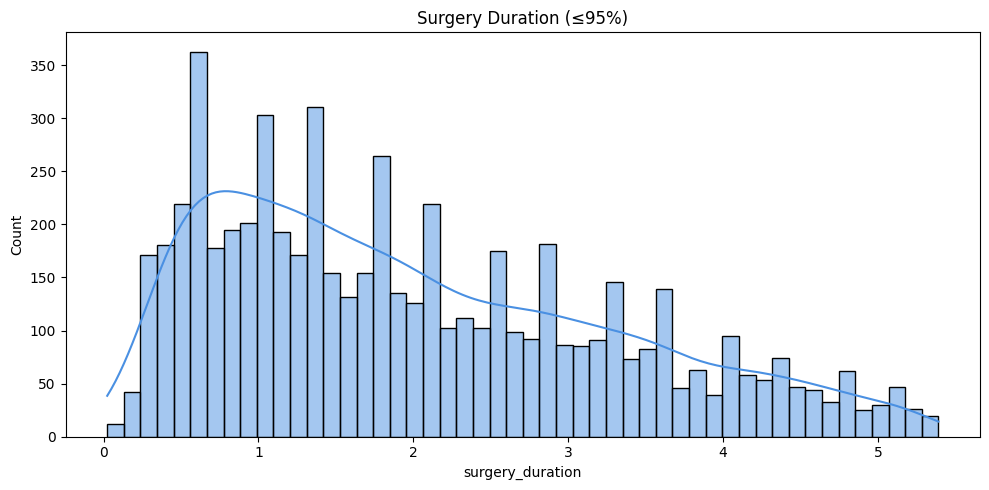

In [124]:
q95 = cases['surgery_duration'].quantile(.95)
plt.figure(figsize=(10,5))
sns.histplot(cases[cases['surgery_duration']<q95]['surgery_duration']/3600,
             bins=50, kde=True, color=MAIN_COLOR)
plt.title("Surgery Duration (≤95%)")
plt.tight_layout()
plt.show()

3.3 ASA vs Surgery Duration

/tmp/ipykernel_3605200/3212489528.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


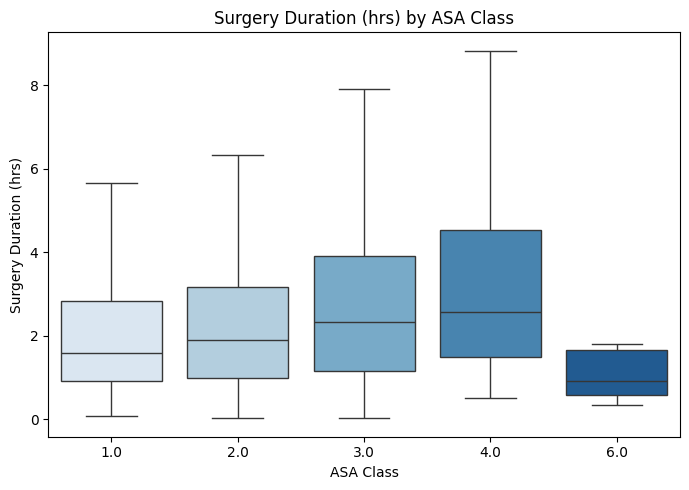

In [125]:
# boxplot
plt.figure(figsize=(7,5))
sns.boxplot(
    x='asa',
    y=cases['surgery_duration']/3600,
    data=cases,
    palette="Blues",
    showfliers=False
)
plt.title("Surgery Duration (hrs) by ASA Class")
plt.xlabel("ASA Class")
plt.ylabel("Surgery Duration (hrs)")
plt.tight_layout()
plt.show()

In [126]:
# ASA별 평균 수술시간
(cases.groupby('asa')['surgery_duration'].mean()/3600).round(2)

asa
1.0    2.01
2.0    2.29
3.0    2.70
4.0    3.46
6.0    1.53
Name: surgery_duration, dtype: float64

In [127]:
# ASA별 중앙 수술시간
(cases.groupby('asa')['surgery_duration'].median()/3600).round(2)

asa
1.0    1.58
2.0    1.90
3.0    2.33
4.0    2.56
6.0    0.92
Name: surgery_duration, dtype: float64

In [128]:
# 상관계수
cases[['asa','surgery_duration']].corr(method='spearman')

asa  surgery_duration
asa               1.000000          0.104885
surgery_duration  0.104885          1.000000

3.4 Anesthesia vs Surgery Duration (Scatter)

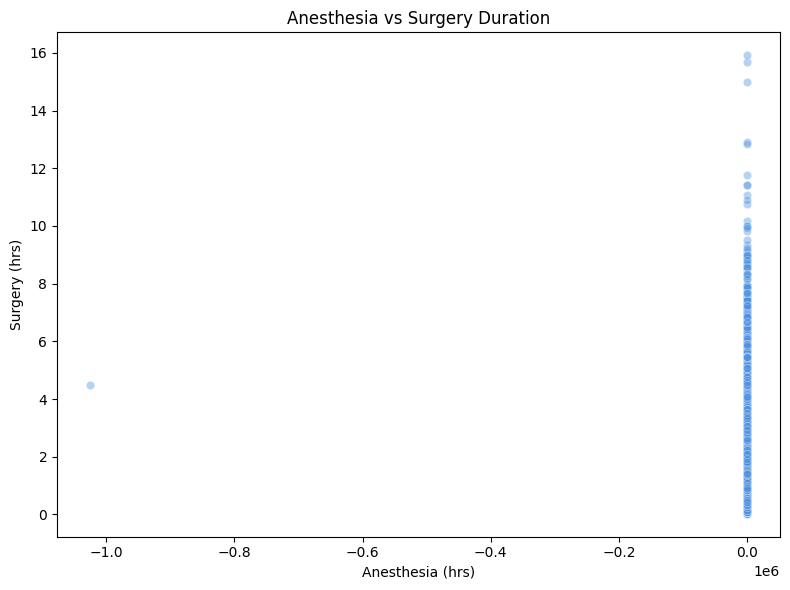

In [129]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=cases['anesthesia_duration']/3600,
    y=cases['surgery_duration']/3600,
    alpha=0.4, color=MAIN_COLOR
)
plt.xlabel("Anesthesia (hrs)")
plt.ylabel("Surgery (hrs)")
plt.title("Anesthesia vs Surgery Duration")
plt.tight_layout()
plt.show()

### 4. Outcome Analysis

4.1 Mortality Distribution

/tmp/ipykernel_3605200/908734961.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='death_inhosp', data=cases, palette="Blues")


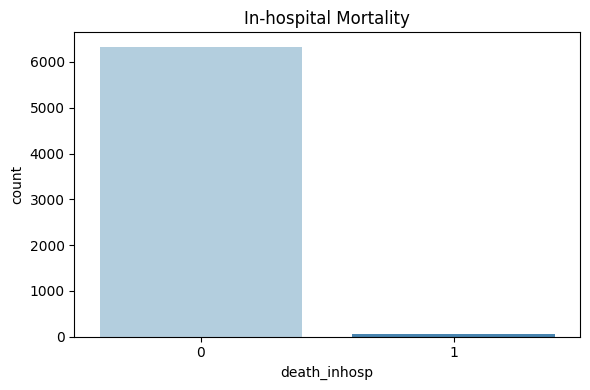

In [130]:
plt.figure(figsize=(6,4))
sns.countplot(x='death_inhosp', data=cases, palette="Blues")
plt.title("In-hospital Mortality")
plt.tight_layout()
plt.show()

In [ ]:
death_ratio = cases['death_inhosp'].mean()*100
death_ratio

np.float64(0.8922980588603632)

4.2 Age Group vs Mortality

In [133]:
# Age group 생성
bins = [0,40,60,80,200]
labels = ['<40','40-60','60-80','80+']
cases['age_group'] = pd.cut(cases['age'], bins=bins, labels=labels, include_lowest=True)

In [134]:
# 절대건수 Cross-table
age_abs = pd.crosstab(cases['age_group'], cases['death_inhosp'])
print("=== Absolute Counts (Age Group vs death_inhosp) ===")
display(age_abs)
print("\nNote: death_inhosp → 0 = Alive, 1 = Death\n")

=== Absolute Counts (Age Group vs death_inhosp) ===


death_inhosp     0   1
age_group             
<40            868  12
40-60         2599  16
60-80         2661  24
80+            203   5


Note: death_inhosp → 0 = Alive, 1 = Death



In [135]:
# 퍼센트 Cross-table
age_pct = pd.crosstab(
    cases['age_group'],
    cases['death_inhosp'],
    normalize='index'
) * 100
print("=== Percentage (Age Group vs death_inhosp) ===")
display(age_pct)
print("\nNote: death_inhosp → 0 = Alive, 1 = Death\n")

=== Percentage (Age Group vs death_inhosp) ===


death_inhosp          0         1
age_group                        
<40           98.636364  1.363636
40-60         99.388145  0.611855
60-80         99.106145  0.893855
80+           97.596154  2.403846


Note: death_inhosp → 0 = Alive, 1 = Death



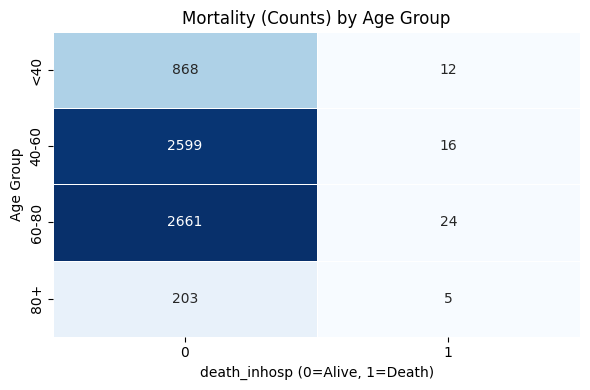

In [136]:
# 절대건수 히트맵
plt.figure(figsize=(6,4))
sns.heatmap(
    age_abs,
    annot=True, fmt="d",
    cmap="Blues",
    linewidths=0.5,
    cbar=False
)
plt.title("Mortality (Counts) by Age Group")
plt.xlabel("death_inhosp (0=Alive, 1=Death)")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


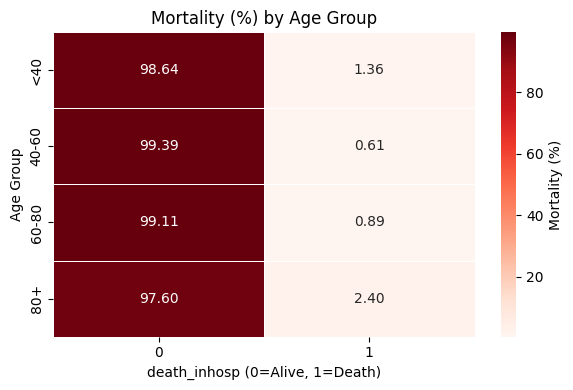

In [137]:
# 퍼센트 히트맵
plt.figure(figsize=(6,4))
sns.heatmap(
    age_pct,
    annot=True, fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={'label': 'Mortality (%)'}
)
plt.title("Mortality (%) by Age Group")
plt.xlabel("death_inhosp (0=Alive, 1=Death)")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


4.3 ASA × Mortality (Heatmap)

In [138]:
# 절대건수 Cross-table
asa_abs = pd.crosstab(cases['asa'], cases['death_inhosp'])
print("=== Absolute Counts (ASA vs death_inhosp) ===")
display(asa_abs)
print("\nNote: death_inhosp → 0 = Alive, 1 = Death\n")

=== Absolute Counts (ASA vs death_inhosp) ===


death_inhosp     0   1
asa                   
1.0           1783   9
2.0           3682  17
3.0            686  17
4.0             36  12
6.0             13   0


Note: death_inhosp → 0 = Alive, 1 = Death



In [139]:
# 퍼센트 Cross-table
asa_pct = pd.crosstab(
    cases['asa'],
    cases['death_inhosp'],
    normalize='index'
) * 100
print("=== Percentage (ASA vs death_inhosp) ===")
display(asa_pct)
print("\nNote: death_inhosp → 0 = Alive, 1 = Death\n")

=== Percentage (ASA vs death_inhosp) ===


death_inhosp           0          1
asa                                
1.0            99.497768   0.502232
2.0            99.540416   0.459584
3.0            97.581792   2.418208
4.0            75.000000  25.000000
6.0           100.000000   0.000000


Note: death_inhosp → 0 = Alive, 1 = Death



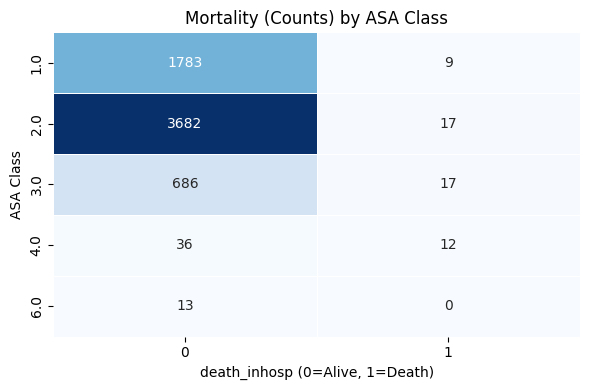

In [140]:
# 절대건수 히트맵
plt.figure(figsize=(6,4))
sns.heatmap(
    asa_abs,
    annot=True, fmt="d",
    cmap="Blues",
    linewidths=0.5,
    cbar=False
)
plt.title("Mortality (Counts) by ASA Class")
plt.xlabel("death_inhosp (0=Alive, 1=Death)")
plt.ylabel("ASA Class")
plt.tight_layout()
plt.show()

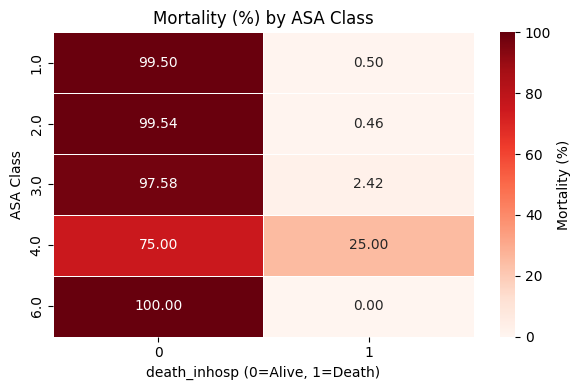

In [141]:
# 퍼센트 히트맵
plt.figure(figsize=(6,4))
sns.heatmap(
    asa_pct,
    annot=True, fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={'label': 'Mortality (%)'}
)
plt.title("Mortality (%) by ASA Class")
plt.xlabel("death_inhosp (0=Alive, 1=Death)")
plt.ylabel("ASA Class")
plt.tight_layout()
plt.show()


4.4 emop vs Mortality

In [142]:
# 절대건수 cross-table
print("=== Absolute Counts (emop vs death_inhosp) ===")
emop_abs = pd.crosstab(cases['emop'], cases['death_inhosp'])
display(emop_abs)
print("\nNote: death_inhosp → 0 = Alive, 1 = Death\n")

=== Absolute Counts (emop vs death_inhosp) ===


death_inhosp     0   1
emop                  
0             5578  28
1              753  29


Note: death_inhosp → 0 = Alive, 1 = Death



In [143]:
# 퍼센트 Cross-table
emop_pct = pd.crosstab(
    cases['emop'],
    cases['death_inhosp'],
    normalize='index'
) * 100
display(emop_pct)
print("\nNote: death_inhosp → 0 = Alive, 1 = Death\n")

death_inhosp          0         1
emop                             
0             99.500535  0.499465
1             96.291560  3.708440


Note: death_inhosp → 0 = Alive, 1 = Death



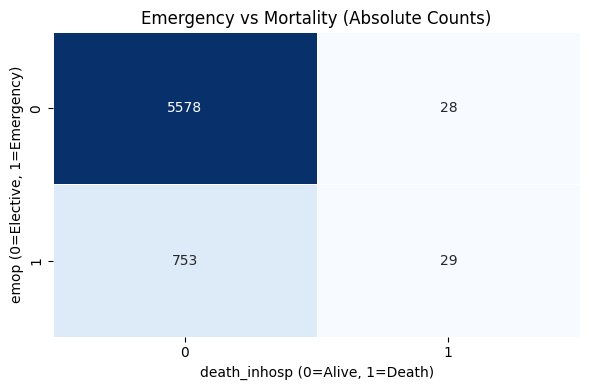

In [144]:
# 절대건수 히트맵
plt.figure(figsize=(6,4))
sns.heatmap(
    emop_abs,
    annot=True, fmt="d", cmap="Blues",
    linewidths=.5, cbar=False
)
plt.title("Emergency vs Mortality (Absolute Counts)")
plt.xlabel("death_inhosp (0=Alive, 1=Death)")
plt.ylabel("emop (0=Elective, 1=Emergency)")
plt.tight_layout()
plt.show()

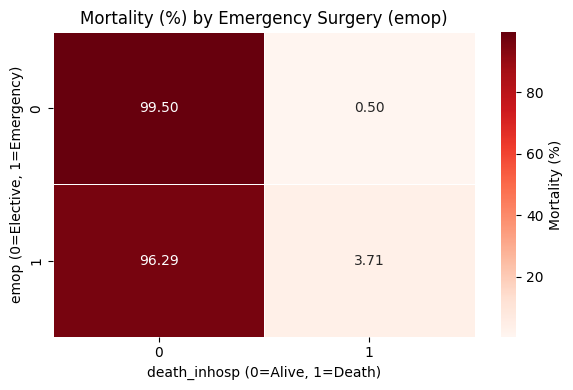

In [145]:
# 퍼센트 히트맵
plt.figure(figsize=(6,4))
sns.heatmap(
    emop_pct,
    annot=True, fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={'label': 'Mortality (%)'}
)
plt.title("Mortality (%) by Emergency Surgery (emop)")
plt.xlabel("death_inhosp (0=Alive, 1=Death)")
plt.ylabel("emop (0=Elective, 1=Emergency)")
plt.tight_layout()
plt.show()


4.5 Surgery Duration vs Mortality

/tmp/ipykernel_3605200/4029882245.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='death_inhosp', y=cases['surgery_duration']/3600,


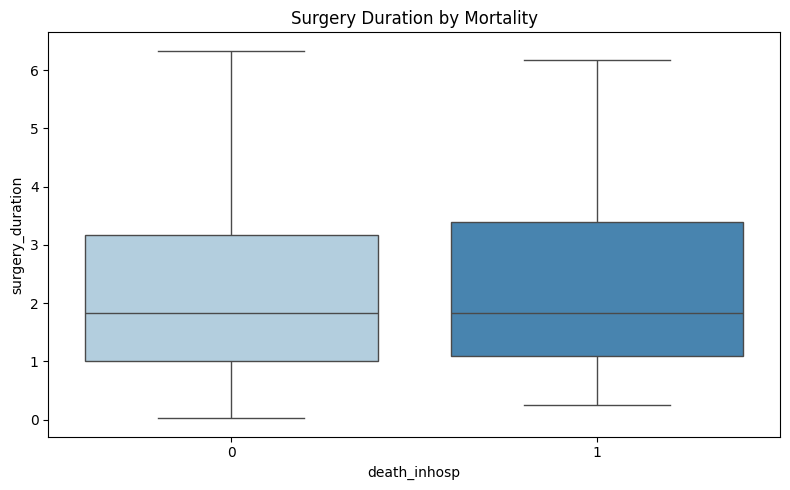

In [146]:
# boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='death_inhosp', y=cases['surgery_duration']/3600,
            data=cases, palette="Blues", showfliers=False)
plt.title("Surgery Duration by Mortality")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3605200/3673595291.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='death_inhosp', y=cases['surgery_duration']/3600,


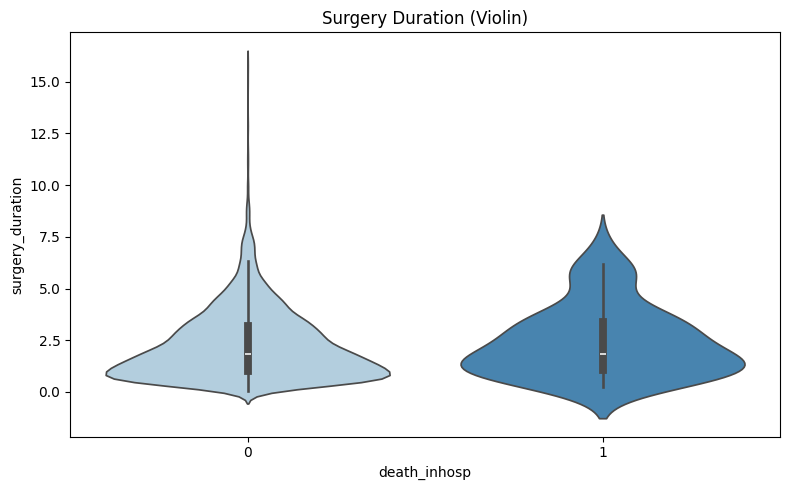

In [147]:
# violin
plt.figure(figsize=(8,5))
sns.violinplot(x='death_inhosp', y=cases['surgery_duration']/3600,
               data=cases, palette="Blues")
plt.title("Surgery Duration (Violin)")
plt.tight_layout()
plt.show()

4.6 ICU Stay

In [148]:
icu_rate = (cases['icu_days']>0).mean()*100
icu_days_desc = cases['icu_days'].describe()
icu_rate, icu_days_desc

(np.float64(18.847839699436445),
 count    6388.000000
 mean        0.552755
 std         3.412307
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max       179.000000
 Name: icu_days, dtype: float64)

### 5. Department & Operation Type

/tmp/ipykernel_3605200/3416668063.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_counts.values, y=dept_counts.index, palette="Blues_r")


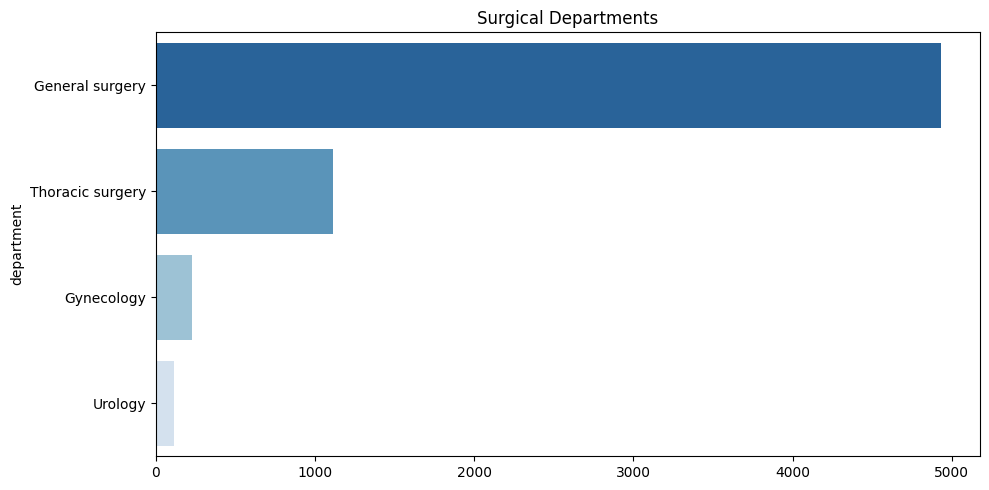

department
General surgery     4930
Thoracic surgery    1111
Gynecology           230
Urology              117
Name: count, dtype: int64

In [149]:
dept_counts = cases['department'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=dept_counts.values, y=dept_counts.index, palette="Blues_r")
plt.title("Surgical Departments")
plt.tight_layout()
plt.show()

dept_counts

5.2 Operation Type

/tmp/ipykernel_3605200/4146399334.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=optype_counts.values, y=optype_counts.index, palette="Greens_r")


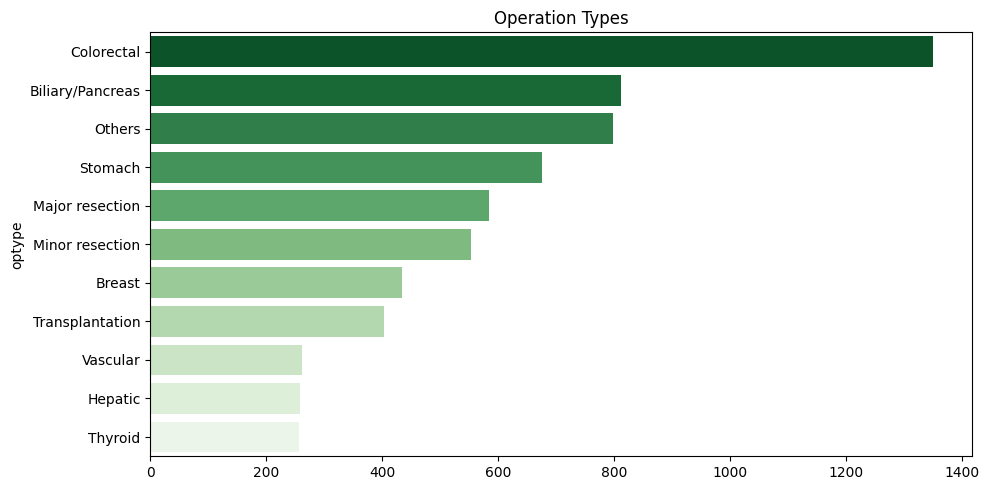

optype
Colorectal          1350
Biliary/Pancreas     812
Others               799
Stomach              676
Major resection      584
Minor resection      553
Breast               434
Transplantation      403
Vascular             262
Hepatic              258
Thyroid              257
Name: count, dtype: int64

In [150]:
optype_counts = cases['optype'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=optype_counts.values, y=optype_counts.index, palette="Greens_r")
plt.title("Operation Types")
plt.tight_layout()
plt.show()

optype_counts

### 6. Additional Case-Level Features

6.1 Comorbidity Cross Tables

In [151]:
pd.crosstab(cases['preop_dm'], cases['death_inhosp'], normalize='index')*100
pd.crosstab(cases['preop_htn'], cases['death_inhosp'], normalize='index')*100

death_inhosp          0         1
preop_htn                        
0             99.140855  0.859145
1             99.033079  0.966921

6.2 LOS (Length of Stay)

In [152]:
cases['los_days'] = (cases['dis'] - cases['adm']) / (24*3600)
cases['los_days'].describe()

count    6388.000000
mean       10.472605
std        14.931167
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max       248.000000
Name: los_days, dtype: float64

7. Correlation Analysis

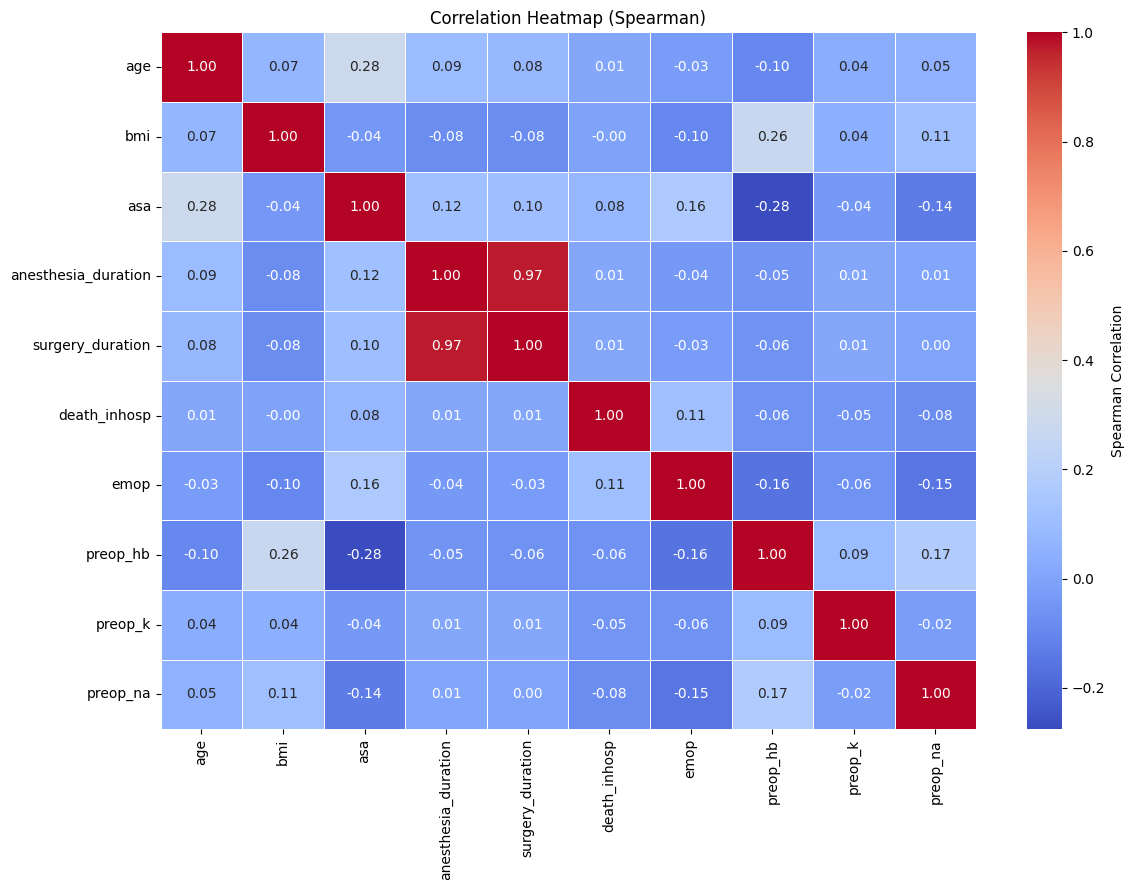

In [ ]:
numeric_cols = [
    'age',             
    'bmi',             
    'asa',             
    'anesthesia_duration',   # 마취 시간
    'surgery_duration',      # 수술 시간
    'death_inhosp',    # 사망 여부 (0/1)
    'emop',            # 응급 여부 (0/1)
    'preop_hb',        # Hb
    'preop_k',         # K+
    'preop_na'         # Na+
]

corr = cases[numeric_cols].corr(method='spearman')

plt.figure(figsize=(12,9))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Spearman Correlation'}
)
plt.title("Correlation Heatmap (Spearman)")
plt.tight_layout()
plt.show()

---

# **2. 고혈압 중심 EDA**

## 사용할 컬럼 선택 + 시간 컬럼 처리 + duration 생성

In [ ]:
cols_keep = [
    "caseid", "subjectid",
    "casestart", "caseend",
    "anestart", "aneend",
    "opstart", "opend",
    "icu_days", "death_inhosp",
    "age", "sex", "height", "weight", "bmi",
    "asa", "emop",
    "department", "optype", "opname",
    "preop_htn", "preop_dm",
    "preop_ecg",  
    "preop_hb", "preop_plt", "preop_pt", "preop_aptt",
    "preop_na", "preop_k", "preop_gluc",
]

cols_keep = [c for c in cols_keep if c in df_cases.columns]
df = df_cases[cols_keep].copy()
print("선택한 컬럼 수:", len(cols_keep))
df.head()


선택한 컬럼 수: 30


caseid  subjectid  casestart  caseend  anestart   aneend  opstart  opend  \
0       1       5955          0    11542      -552  10848.0     1668  10368   
1       2       2487          0    15741     -1039  14921.0     1721  14621   
2       3       2861          0     4394      -590   4210.0     1090   3010   
3       4       1903          0    20990      -778  20222.0     2522  17822   
4       5       4416          0    21531     -1009  22391.0     2591  20291   

   icu_days  death_inhosp  ...  preop_htn preop_dm  \
0         0             0  ...          1        0   
1         0             0  ...          0        0   
2         0             0  ...          0        0   
3         1             0  ...          1        0   
4        13             0  ...          1        0   

                        preop_ecg  preop_hb  preop_plt  preop_pt  preop_aptt  \
0             Normal Sinus Rhythm      14.1      189.0      94.0        33.2   
1             Normal Sinus Rhythm      10.2      251.0     110.0        31.9   
2             Normal Sinus Rhythm      14.2      373.0     103.0        30.3   
3             Normal Sinus Rhythm      14.4      275.0     103.0        34.5   
4  Left anterior fascicular block      10.1       67.0      73.0        36.5   

  preop_na preop_k preop_gluc  
0    141.0     3.1      134.0  
1    143.0     4.7       88.0  
2    144.0     4.9       87.0  
3    141.0     4.2      108.0  
4    146.0     4.4      126.0  

[5 rows x 30 columns]

In [5]:
# 시간 컬럼을 datetime으로 변환 (초 단위)
time_cols = ["casestart", "caseend", "anestart", "aneend", "opstart", "opend"]
for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], unit="s", errors="coerce")

# 수술/마취 duration 계산 (분 단위)
if set(["opstart", "opend"]).issubset(df.columns):
    df["op_duration_min"] = (df["opend"] - df["opstart"]).dt.total_seconds() / 60.0

if set(["anestart", "aneend"]).issubset(df.columns):
    df["ane_duration_min"] = (df["aneend"] - df["anestart"]).dt.total_seconds() / 60.0

df[["op_duration_min", "ane_duration_min"]].describe()

op_duration_min  ane_duration_min
count      6388.000000      6.388000e+03
mean        135.985462     -9.431647e+03
std         101.161685      7.697804e+05
min           1.416667     -6.152447e+07
25%          60.000000      1.120000e+02
50%         110.000000      1.750000e+02
75%         190.000000      2.600000e+02
max         955.000000      1.860000e+03

## 기본 필터링 + 타겟(고혈압) 확인

In [6]:
# 성인만 사용 + 고혈압 정보 있는 케이스만 사용
n_before = len(df)

if "age" in df.columns:
    df = df[df["age"] >= 18]

df = df[~df["preop_htn"].isna()] 

n_after = len(df)
print(f"필터링 전: {n_before}건 -> 필터링 후: {n_after}건")

# 타겟 분포 확인 (preop_htn: 0=정상, 1=고혈압)
htn_prop = df["preop_htn"].value_counts(normalize=True) * 100
print("HTN distribution (%):")
print(htn_prop)

필터링 전: 6388건 -> 필터링 후: 6331건
HTN distribution (%):
preop_htn
0    68.978045
1    31.021955
Name: proportion, dtype: float64


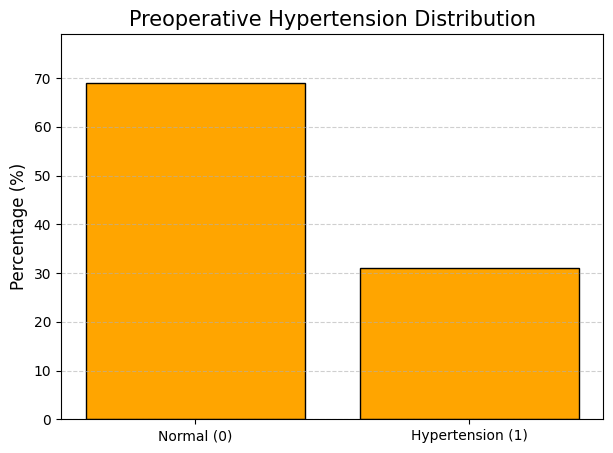

In [154]:
htn_prop = df["preop_htn"].value_counts(normalize=True) * 100

htn_prop = htn_prop.sort_index()

plt.figure(figsize=(7, 5))
plt.bar(
    ["Normal (0)", "Hypertension (1)"],
    htn_prop.values,
    color='orange',
    edgecolor='black'
)

plt.title("Preoperative Hypertension Distribution", fontsize=15)
plt.ylabel("Percentage (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.ylim(0, max(htn_prop.values) + 10)

plt.show()

## 연속형/범주형 변수 리스트 정의 + 간단 전처리

In [7]:
# 분석에 사용할 연속형 변수
num_cols = [
    "age",
    "bmi",
    "preop_hb", "preop_plt", "preop_pt", "preop_aptt",
    "preop_na", "preop_k", "preop_gluc",
    "op_duration_min", "ane_duration_min",
]

num_cols = [c for c in num_cols if c in df.columns]

# 분석에 사용할 범주형 변수
cat_cols = [
    "sex",
    "department",
    "optype",
    "asa",
    "emop",
    "preop_dm",
]

cat_cols = [c for c in cat_cols if c in df.columns]

print("연속형 변수:", num_cols)
print("범주형 변수:", cat_cols)


연속형 변수: ['age', 'bmi', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'op_duration_min', 'ane_duration_min']
범주형 변수: ['sex', 'department', 'optype', 'asa', 'emop', 'preop_dm']


In [ ]:
# 연속형 변수 결측률 확인
(df[num_cols].isna().mean() * 100).round(1)

age                 0.0
bmi                 0.0
preop_hb            5.3
preop_plt           5.3
preop_pt            6.1
preop_aptt          6.3
preop_na            9.8
preop_k             9.7
preop_gluc          5.9
op_duration_min     0.0
ane_duration_min    0.0
dtype: float64

In [ ]:
# 연속형 변수 결측값은 중앙값으로 대체
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

In [ ]:
pd.set_option('display.max_rows', None)   
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)       
pd.set_option('display.max_colwidth', None)

In [11]:
# 연속형 변수 group별 요약
df.groupby("preop_htn")[num_cols].describe().T

preop_htn                         0             1
age              count  4367.000000  1.964000e+03
                 mean     54.303183  6.533096e+01
                 std      14.298568  1.113953e+01
                 min      18.000000  2.200000e+01
                 25%      45.000000  5.800000e+01
                 50%      56.000000  6.600000e+01
                 75%      64.000000  7.400000e+01
                 max      94.000000  9.100000e+01
bmi              count  4367.000000  1.964000e+03
                 mean     22.909183  2.422632e+01
                 std       3.516478  3.586686e+00
                 min      11.300000  1.450000e+01
                 25%      20.600000  2.180000e+01
                 50%      22.700000  2.410000e+01
                 75%      24.900000  2.630000e+01
                 max      42.800000  4.320000e+01
preop_hb         count  4367.000000  1.964000e+03
                 mean     12.934898  1.269781e+01
                 std       1.892503  1.963039e+00
                 min       3.500000  6.100000e+00
                 25%      11.900000  1.150000e+01
                 50%      13.000000  1.290000e+01
                 75%      14.200000  1.410000e+01
                 max      20.200000  1.870000e+01
preop_plt        count  4367.000000  1.964000e+03
                 mean    242.400733  2.394476e+02
                 std      81.989216  8.242120e+01
                 min       5.000000  2.400000e+01
                 25%     196.000000  1.910000e+02
                 50%     235.000000  2.350000e+02
                 75%     282.000000  2.750000e+02
                 max    1156.000000  8.470000e+02
preop_pt         count  4367.000000  1.964000e+03
                 mean     99.741470  1.026141e+02
                 std      14.487560  1.446642e+01
                 min      14.000000  2.700000e+01
                 25%      94.000000  9.600000e+01
                 50%     101.000000  1.030000e+02
                 75%     107.000000  1.110000e+02
                 max     159.000000  1.530000e+02
preop_aptt       count  4367.000000  1.964000e+03
                 mean     32.956538  3.236049e+01
                 std       9.183292  4.846595e+00
                 min      19.200000  1.990000e+01
                 25%      30.400000  2.980000e+01
                 50%      32.100000  3.190000e+01
                 75%      34.300000  3.392500e+01
                 max     400.000000  1.013000e+02
preop_na         count  4367.000000  1.964000e+03
                 mean    140.105564  1.399236e+02
                 std       2.614065  2.965461e+00
                 min     111.000000  1.190000e+02
                 25%     139.000000  1.390000e+02
                 50%     140.000000  1.400000e+02
                 75%     142.000000  1.420000e+02
                 max     150.000000  1.480000e+02
preop_k          count  4367.000000  1.964000e+03
                 mean      4.193497  4.207434e+00
                 std       0.364477  4.244990e-01
                 min       2.500000  2.600000e+00
                 25%       4.000000  4.000000e+00
                 50%       4.200000  4.200000e+00
                 75%       4.400000  4.400000e+00
                 max       8.400000  6.300000e+00
preop_gluc       count  4367.000000  1.964000e+03
                 mean    111.562629  1.225244e+02
                 std      38.314508  4.525505e+01
                 min      44.000000  4.500000e+01
                 25%      94.000000  9.800000e+01
                 50%     103.000000  1.080000e+02
                 75%     115.000000  1.320000e+02
                 max     525.000000  5.110000e+02
op_duration_min  count  4367.000000  1.964000e+03
                 mean    131.927757  1.436809e+02
                 std     100.037531  1.007403e+02
                 min       2.000000  1.416667e+00
                 25%      55.000000  6.500000e+01
                 50%     105.000000  1.200000e+02
                 75%     180.000000  2.050000e+02


In [12]:
# 범주형 변수 cross-tab (열 기준 비율 %)
for col in cat_cols:
    print(f"\n=== {col} ===")
    display(pd.crosstab(df[col], df["preop_htn"], normalize="columns") * 100)



=== sex ===


preop_htn          0          1
sex                            
F          51.568583  43.788187
M          48.431417  56.211813


=== department ===


preop_htn                 0          1
department                            
General surgery   76.116327  79.327902
Gynecology         4.488207   1.629328
Thoracic surgery  17.769636  16.751527
Urology            1.625830   2.291242


=== optype ===


preop_htn                 0          1
optype                                
Biliary/Pancreas  12.731853  13.034623
Breast             7.785665   4.786151
Colorectal        19.853446  24.389002
Hepatic            3.915732   4.429735
Major resection    9.045111   9.521385
Minor resection    9.205404   7.535642
Others            13.487520  10.132383
Stomach           10.144264  11.812627
Thyroid            4.671399   2.698574
Transplantation    5.999542   5.957230
Vascular           3.160064   5.702648


=== asa ===


preop_htn          0          1
asa                            
1.0        39.455782   5.216942
2.0        52.099460  75.671488
3.0         7.741027  18.078512
4.0         0.445696   0.929752
6.0         0.258034   0.103306


=== emop ===


preop_htn          0          1
emop                           
0          88.435997  87.016293
1          11.564003  12.983707


=== preop_dm ===


preop_htn          0          1
preop_dm                       
0          92.534921  82.942974
1           7.465079  17.057026

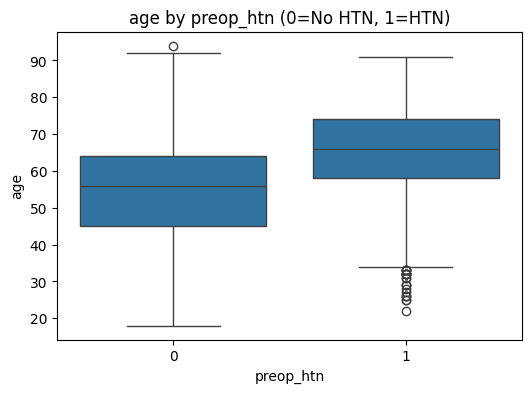

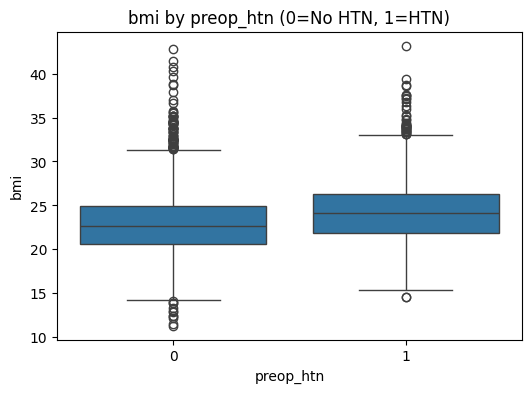

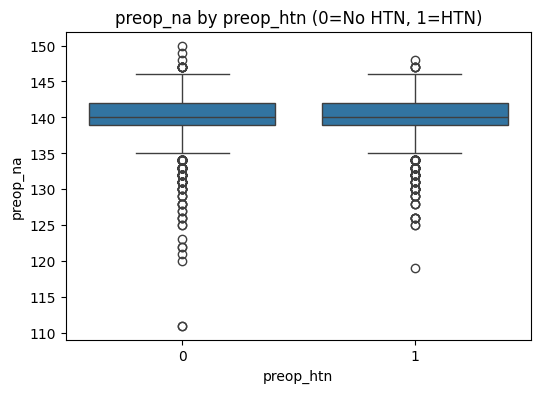

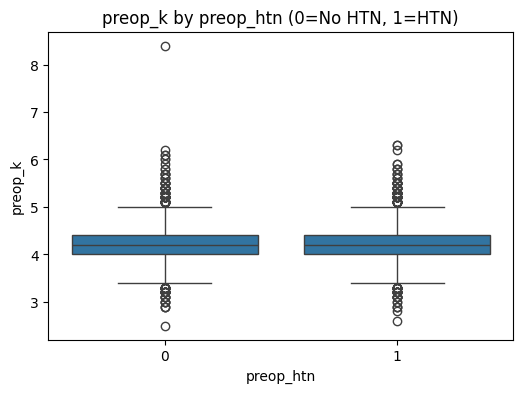

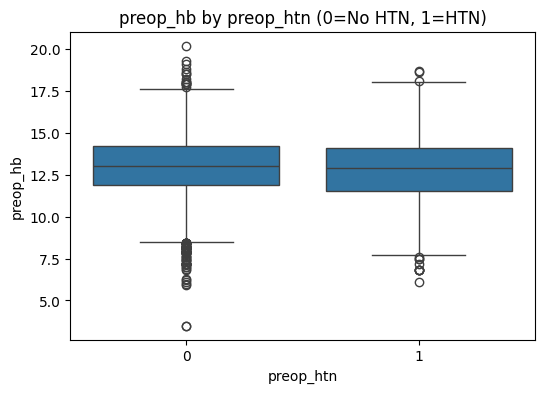

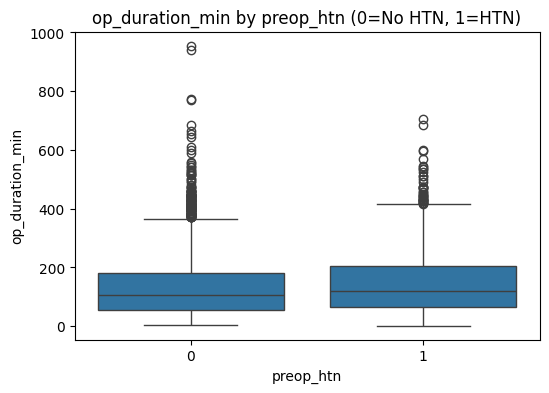

In [13]:
# 연속형: boxplot
plot_cols = ["age", "bmi", "preop_na", "preop_k", "preop_hb", "op_duration_min"]
plot_cols = [c for c in plot_cols if c in df.columns]

for col in plot_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="preop_htn", y=col)
    plt.title(f"{col} by preop_htn (0=No HTN, 1=HTN)")
    plt.xlabel("preop_htn")
    plt.ylabel(col)
    plt.show()


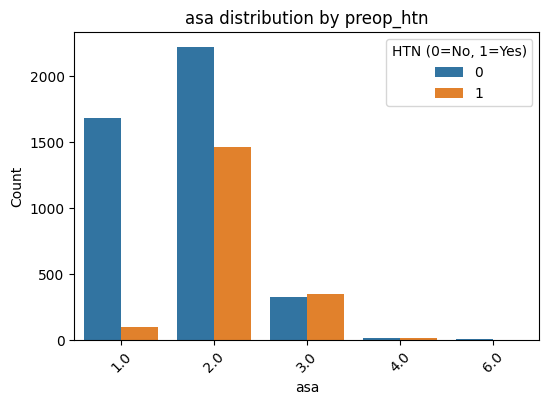

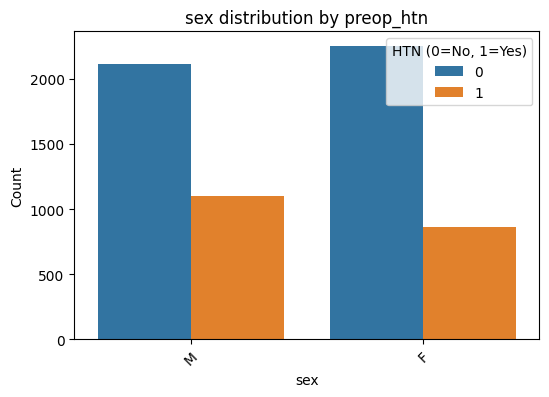

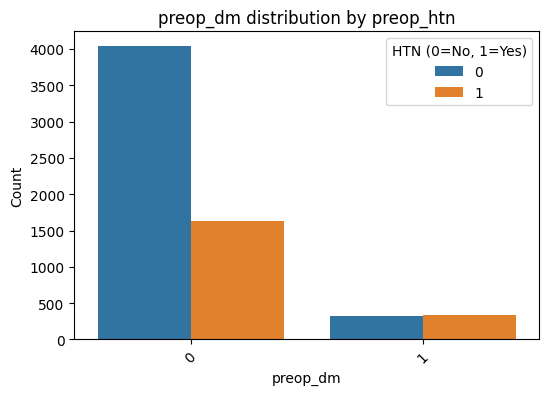

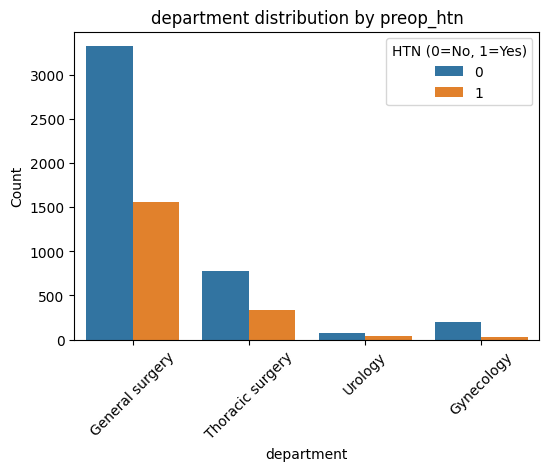

In [14]:
# 5-2. 범주형: countplot
cat_plot_cols = ["asa", "sex", "preop_dm", "department"]
cat_plot_cols = [c for c in cat_plot_cols if c in df.columns]

for col in cat_plot_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue="preop_htn")
    plt.title(f"{col} distribution by preop_htn")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="HTN (0=No, 1=Yes)")
    plt.show()


---

# **3. 단일-Feature-Focused Regression Analysis**

In [15]:
# 연속형 변수: Mann-Whitney U test
df0 = df[df["preop_htn"] == 0]
df1 = df[df["preop_htn"] == 1]

print("=== Mann-Whitney U test (numeric vars) ===")
for col in num_cols:
    try:
        stat, p = mannwhitneyu(df0[col], df1[col], alternative="two-sided")
        print(f"{col:20s} p-value = {p:.4f}")
    except Exception as e:
        print(f"{col:20s} ERROR: {e}")

=== Mann-Whitney U test (numeric vars) ===
age                  p-value = 0.0000
bmi                  p-value = 0.0000
preop_hb             p-value = 0.0000
preop_plt            p-value = 0.0058
preop_pt             p-value = 0.0000
preop_aptt           p-value = 0.0000
preop_na             p-value = 0.2445
preop_k              p-value = 0.4921
preop_gluc           p-value = 0.0000
op_duration_min      p-value = 0.0000
ane_duration_min     p-value = 0.0000


In [16]:
# 범주형 변수: Chi-square test
print("\n=== Chi-square test (categorical vars) ===")
for col in cat_cols:
    table = pd.crosstab(df[col], df["preop_htn"])
    chi2, p, dof, exp = chi2_contingency(table)
    print(f"{col:20s} p-value = {p:.4f}")


=== Chi-square test (categorical vars) ===
sex                  p-value = 0.0000
department           p-value = 0.0000
optype               p-value = 0.0000
asa                  p-value = 0.0000
emop                 p-value = 0.1174
preop_dm             p-value = 0.0000


## 회귀 1: statsmodels Logistic Regression (고혈압 ~ 임상 변수)

In [ ]:
features_num = num_cols.copy()
features_cat = cat_cols.copy()

# one-hot 인코딩
df_reg = df[features_num + features_cat + ["preop_htn"]].copy()
df_reg = pd.get_dummies(df_reg, columns=features_cat, drop_first=True)

# bool → int 변환
df_reg = df_reg.replace({True: 1, False: 0})

# 결측 제거
df_reg = df_reg.dropna()

# y, X 분리
y = df_reg["preop_htn"].astype(int)
X = df_reg.drop(columns=["preop_htn"])

# 상수항 추가
X_const = sm.add_constant(X).astype(float)

# Logistic Regression
logit_model = sm.Logit(y, X_const)
result = logit_model.fit(disp=False)

result.summary()


/tmp/ipykernel_3605200/2509840504.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reg = df_reg.replace({True: 1, False: 0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6299
Method:                           MLE   Df Model:                           31
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.2356
Time:                        14:21:42   Log-Likelihood:                -2996.8
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -8.3296      1.747     -4.768      0.000     -11.753      -4.906
age                             0.0596      0.003     20.181      0.000       0.054       0.065
bmi                             0.1385      0.010     14.201      0.000       0.119       0.158
preop_hb                       -0.0078      0.020     -0.395      0.693      -0.046       0.031
preop_plt                       0.0018      0.000      4.458      0.000       0.001       0.003
preop_pt                        0.0168      0.002      7.022      0.000       0.012       0.021
preop_aptt                      0.0015      0.004      0.343      0.732      -0.007       0.010
preop_na                       -0.0188      0.012     -1.571      0.116      -0.042       0.005
preop_k                        -0.1223      0.083     -1.470      0.142      -0.285       0.041
preop_gluc                      0.0001      0.001      0.176      0.860      -0.001       0.002
op_duration_min                 0.0002      0.001      0.179      0.858      -0.002       0.003
ane_duration_min               -0.0002      0.001     -0.144      0.886      -0.003       0.002
sex_M                           0.0913      0.074      1.236      0.216      -0.053       0.236
department_Gynecology          -0.4385      0.299     -1.467      0.142      -1.024       0.147
department_Thoracic surgery    -0.2896      0.193     -1.497      0.134      -0.669       0.090
department_Urology             -0.1848      0.301     -0.614      0.539      -0.775       0.405
optype_Breast                  -0.0228      0.171     -0.134      0.894      -0.357       0.312
optype_Colorectal              -0.0221      0.113     -0.195      0.845      -0.243       0.199
optype_Hepatic                 -0.0983      0.175     -0.562      0.574      -0.441       0.244
optype_Major resection          0.0594      0.239      0.249      0.804      -0.409       0.527
optype_Minor resection         -0.1035      0.240     -0.432      0.666      -0.574       0.367
optype_Others                  -0.1806      0.151     -1.197      0.231      -0.477       0.115
optype_Stomach                  0.1701      0.134      1.271      0.204      -0.092       0.432
optype_Thyroid                 -0.0643      0.199     -0.323      0.747      -0.455       0.326
optype_Transplantation          0.8519      0.184      4.620      0.000       0.491       1.213
optype_Vascular                 0.3472      0.177      1.966      0.049       0.001       0.693
asa_2.0                         1.9406      0.104     18.627      0.000       1.736       2.145
asa_3.0                         2.5359      0.140     18.089      0.000       2.261       2.811
asa_4.0                         2.1935      0.403      5.443      0.000       1.404       2.983
asa_6.0                         1.6522      0.995      1.660      0.097      -0.298       3.603
emop_1                          0.2458      0.104      2.361      0.018  

In [18]:
#  계수 + 오즈비(odds ratio) 정리
coef = result.params
pvals = result.pvalues

odds = np.exp(coef)
summary_table = pd.DataFrame({
    "coef": coef,
    "odds_ratio": odds,
    "p_value": pvals
}).sort_values("odds_ratio", ascending=False)

summary_table.head(20)

coef  odds_ratio       p_value
asa_3.0                 2.535931   12.628181  3.918037e-73
asa_4.0                 2.193486    8.966412  5.251746e-08
asa_2.0                 1.940572    6.962734  1.943570e-77
asa_6.0                 1.652150    5.218187  9.689550e-02
optype_Transplantation  0.851944    2.344200  3.837347e-06
optype_Vascular         0.347166    1.415052  4.930314e-02
emop_1                  0.245751    1.278581  1.821027e-02
preop_dm_1              0.206830    1.229773  3.333892e-02
optype_Stomach          0.170101    1.185425  2.037329e-01
bmi                     0.138486    1.148534  9.065777e-46
sex_M                   0.091288    1.095584  2.164907e-01
age                     0.059587    1.061398  1.449058e-90
optype_Major resection  0.059390    1.061189  8.035980e-01
preop_pt                0.016785    1.016927  2.180243e-12
preop_plt               0.001785    1.001786  8.289568e-06
preop_aptt              0.001474    1.001475  7.319691e-01
op_duration_min         0.000243    1.000243  8.579022e-01
preop_gluc              0.000136    1.000136  8.599533e-01
ane_duration_min       -0.000176    0.999824  8.856324e-01
preop_hb               -0.007775    0.992255  6.925438e-01

### 시각화: 상위 중요한 피처들 오즈비 플롯

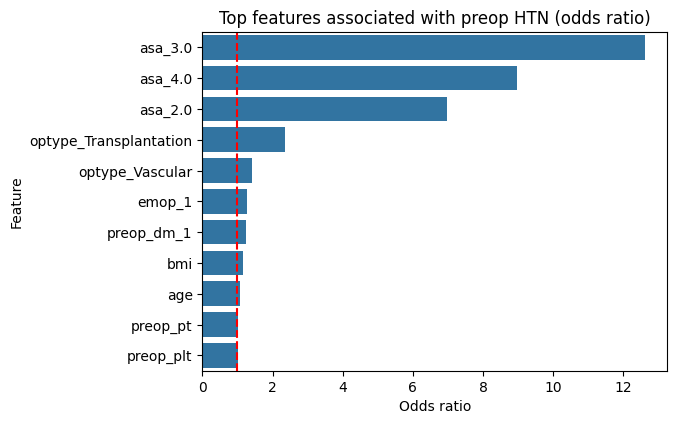

In [ ]:
# 유의한 피처들만 (p < 0.05) 
sig = summary_table[(summary_table["p_value"] < 0.05) & (summary_table.index != "const")]

top_n = 15
sig_top = sig.sort_values("odds_ratio", ascending=False).head(top_n)

plt.figure(figsize=(6, 0.4*len(sig_top)))
sns.barplot(x="odds_ratio", y=sig_top.index, data=sig_top)
plt.axvline(1.0, color="red", linestyle="--")
plt.title("Top features associated with preop HTN (odds ratio)")
plt.xlabel("Odds ratio")
plt.ylabel("Feature")
plt.show()


## 3-1 ASA vs 고혈압(HTN)

In [ ]:
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

# ASA / HTN / age / bmi 
cols_need = ["preop_htn", "asa", "age", "bmi"]
dfa = df[cols_need].copy()

# 결측 제거
dfa = dfa.dropna(subset=["preop_htn", "asa"])

# ASA를 정수 카테고리로 (1,2,3,4,5,6 ...)
dfa["asa_cat"] = dfa["asa"].astype(int)

# HTN: int(0/1)
dfa["preop_htn"] = dfa["preop_htn"].astype(int)

print(dfa.head())
print(dfa["asa_cat"].value_counts().sort_index())


   preop_htn  asa   age   bmi  asa_cat
0          1  2.0  77.0  26.3        2
1          0  2.0  54.0  19.6        2
2          0  1.0  62.0  24.4        1
3          1  2.0  74.0  20.5        2
4          1  3.0  66.0  20.4        3
asa_cat
1    1783
2    3686
3     680
4      37
6      13
Name: count, dtype: int64


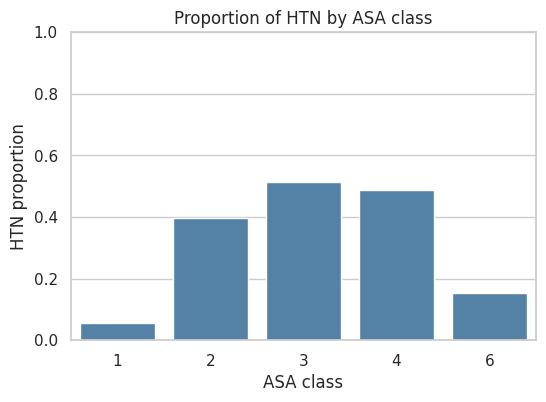

asa_cat  htn_rate
0        1  0.056646
1        2  0.397450
2        3  0.514706
3        4  0.486486
4        6  0.153846

In [21]:
# ASA 등급별 HTN 비율
asa_htn_prop = (
    dfa.groupby("asa_cat")["preop_htn"]
       .mean()
       .reset_index()
       .rename(columns={"preop_htn": "htn_rate"})
)

plt.figure(figsize=(6,4))
sns.barplot(data=asa_htn_prop, x="asa_cat", y="htn_rate", color="steelblue")
plt.title("Proportion of HTN by ASA class")
plt.xlabel("ASA class")
plt.ylabel("HTN proportion")
plt.ylim(0, 1)
plt.show()

asa_htn_prop


In [22]:
# ASA × HTN 교차표
ct = pd.crosstab(dfa["asa_cat"], dfa["preop_htn"])
print(ct)

chi2, p, dof, expected = chi2_contingency(ct)
print("\n=== Chi-square test: ASA vs preop_htn ===")
print(f"chi2 = {chi2:.3f}, dof = {dof}, p-value = {p:.3e}")

preop_htn     0     1
asa_cat              
1          1682   101
2          2221  1465
3           330   350
4            19    18
6            11     2

=== Chi-square test: ASA vs preop_htn ===
chi2 = 803.493, dof = 4, p-value = 1.345e-172


In [ ]:
# 회귀에 필요한 행만 (age, bmi 결측 제거)
df_reg = dfa.dropna(subset=["age", "bmi", "asa_cat"]).copy()

# 로지스틱 회귀: preop_htn ~ ASA(범주) + age + bmi
model = smf.logit("preop_htn ~ C(asa_cat) + age + bmi", data=df_reg).fit(disp=False)
print(model.summary())

# 계수 → OR 변환
params = model.params
conf = model.conf_int()
or_df = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "OR_low": np.exp(conf[0]),
    "OR_high": np.exp(conf[1]),
    "p_value": model.pvalues
})

# ASA 관련 항만 정리 
asa_or = (
    or_df
    .loc[or_df.index.str.contains("C\(asa_cat\)"), :]
    .copy()
)
asa_or


                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6199
Model:                          Logit   Df Residuals:                     6192
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.2206
Time:                        14:21:43   Log-Likelihood:                -3000.1
converged:                       True   LL-Null:                       -3849.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -9.1718      0.313    -29.343      0.000      -9.784      -8.559
C(asa_cat)[T.2]     2.0232      0.112     18.112      0.000       1.804       2.242
C(asa_cat)[T.3]     2.6994      

coef         OR     OR_low    OR_high       p_value
C(asa_cat)[T.2]  2.023203   7.562513   6.075534   9.413428  2.545822e-73
C(asa_cat)[T.3]  2.699353  14.870101  11.367771  19.451476  2.188521e-86
C(asa_cat)[T.4]  2.397340  10.993893   5.043866  23.962904  1.635401e-09
C(asa_cat)[T.6]  1.647213   5.192489   0.921607  29.255355  6.184373e-02

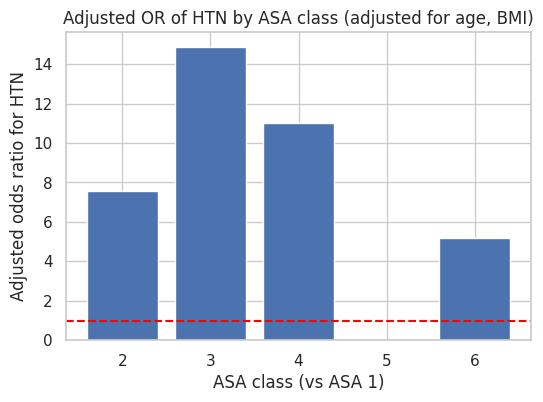

asa_level         OR     OR_low    OR_high       p_value
C(asa_cat)[T.2]          2   7.562513   6.075534   9.413428  2.545822e-73
C(asa_cat)[T.3]          3  14.870101  11.367771  19.451476  2.188521e-86
C(asa_cat)[T.4]          4  10.993893   5.043866  23.962904  1.635401e-09
C(asa_cat)[T.6]          6   5.192489   0.921607  29.255355  6.184373e-02

In [24]:
# index ex: C(asa_cat)[T.2], C(asa_cat)[T.3] ...
asa_or_plot = asa_or.copy()
asa_or_plot["asa_level"] = (
    asa_or_plot.index
    .str.extract(r"C\(asa_cat\)\[T\.(\d+)\]", expand=False)
    .astype(int)
)

asa_or_plot = asa_or_plot.sort_values("asa_level")

plt.figure(figsize=(6,4))
plt.bar(asa_or_plot["asa_level"], asa_or_plot["OR"])
plt.axhline(1.0, color="red", linestyle="--")
plt.xlabel("ASA class (vs ASA 1)")
plt.ylabel("Adjusted odds ratio for HTN")
plt.title("Adjusted OR of HTN by ASA class (adjusted for age, BMI)")
plt.show()

asa_or_plot[["asa_level", "OR", "OR_low", "OR_high", "p_value"]]


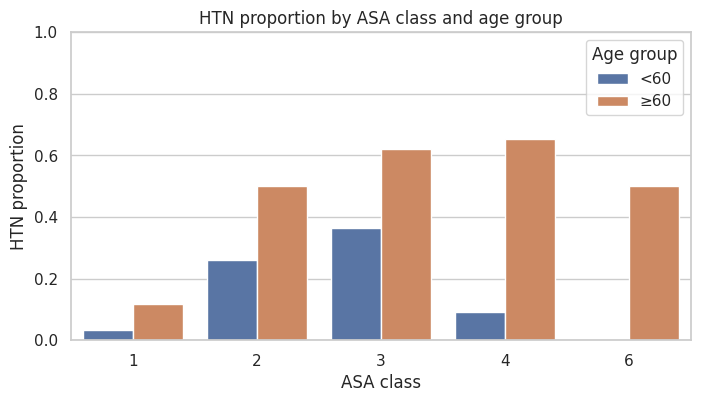

age_group  asa_cat  htn_rate
0       <60        1  0.033846
1       <60        2  0.259987
2       <60        3  0.362989
3       <60        4  0.090909
4       <60        6  0.000000
5       ≥60        1  0.118012
6       ≥60        2  0.500237
7       ≥60        3  0.621554
8       ≥60        4  0.653846
9       ≥60        6  0.500000

In [ ]:
# 나이 기준 subgroup 나누기 (60세 기준)
dfa["age_group"] = np.where(dfa["age"] < 60, "<60", "≥60")

# 각 그룹에서 ASA별 HTN 비율 계산
sub_props = (
    dfa.groupby(["age_group", "asa_cat"])["preop_htn"]
       .mean()
       .reset_index()
       .rename(columns={"preop_htn": "htn_rate"})
)

plt.figure(figsize=(8,4))
sns.barplot(
    data=sub_props,
    x="asa_cat", y="htn_rate",
    hue="age_group"
)
plt.title("HTN proportion by ASA class and age group")
plt.xlabel("ASA class")
plt.ylabel("HTN proportion")
plt.ylim(0, 1)
plt.legend(title="Age group")
plt.show()

sub_props


## 3-2. 수술 종류(Optype) vs 고혈압 분석 코드

In [ ]:
df2 = df.copy()

# optype 빈도
print(df2['optype'].value_counts())
print("\nUnique optypes:", df2['optype'].nunique())

optype
Colorectal          1346
Biliary/Pancreas     812
Others               788
Stomach              675
Major resection      582
Minor resection      550
Breast               434
Transplantation      379
Hepatic              258
Thyroid              257
Vascular             250
Name: count, dtype: int64

Unique optypes: 11


### 1) Optype별 HTN 비율

In [27]:
# cross-tab HTN 비율
op_htn = (df2.groupby('optype')['preop_htn']
             .mean()
             .reset_index()
             .sort_values(by='preop_htn', ascending=False))

op_htn

optype  preop_htn
10          Vascular   0.448000
2         Colorectal   0.355869
7            Stomach   0.343704
3            Hepatic   0.337209
4    Major resection   0.321306
0   Biliary/Pancreas   0.315271
9    Transplantation   0.308707
5    Minor resection   0.269091
6             Others   0.252538
1             Breast   0.216590
8            Thyroid   0.206226

/tmp/ipykernel_3605200/3695418082.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=op_htn, x='preop_htn', y='optype', palette='viridis')


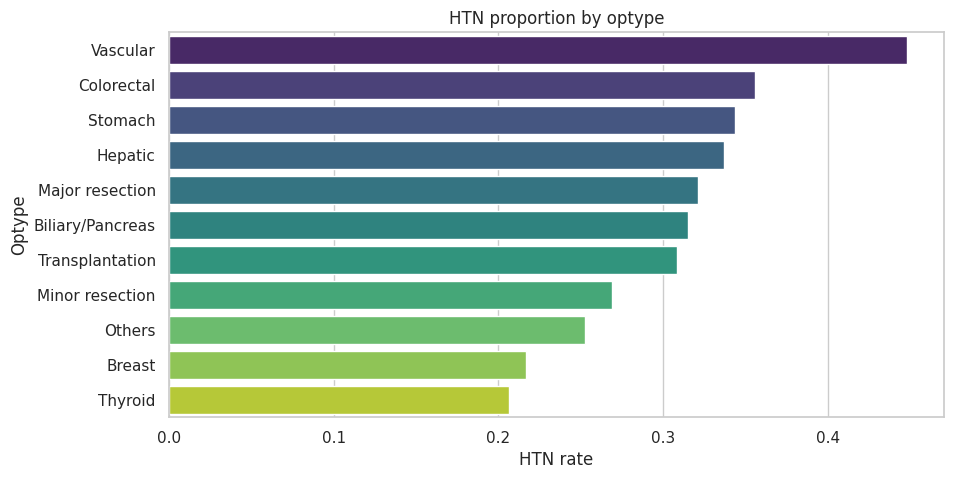

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(data=op_htn, x='preop_htn', y='optype', palette='viridis')
plt.title("HTN proportion by optype")
plt.xlabel("HTN rate")
plt.ylabel("Optype")
plt.show()

| Optype               | 설명        |
| -------------------- | --------- |
| **Vascular**         | 혈관 수술     |
| **Colorectal**       | 대장·직장 수술  |
| **Stomach**          | 위 수술      |
| **Hepatic**          | 간 수술      |
| **Major resection**  | 광범위 절제 수술 |
| **Biliary/Pancreas** | 담도·췌장 수술  |
| **Transplantation**  | 장기 이식 수술  |
| **Minor resection**  | 소규모 절제 수술 |
| **Others**           | 기타 수술     |
| **Breast**           | 유방 수술     |
| **Thyroid**          | 갑상선 수술    |


### 2) 카이제곱 검정 (Optype vs HTN)

In [29]:
ct = pd.crosstab(df2['optype'], df2['preop_htn'])
print(ct)

chi2, p, dof, exp = chi2_contingency(ct)
print("\n=== Chi-square test: optype vs HTN ===")
print(f"chi2 = {chi2:.3f}, dof = {dof}, p-value = {p:.3e}")

preop_htn           0    1
optype                    
Biliary/Pancreas  556  256
Breast            340   94
Colorectal        867  479
Hepatic           171   87
Major resection   395  187
Minor resection   402  148
Others            589  199
Stomach           443  232
Thyroid           204   53
Transplantation   262  117
Vascular          138  112

=== Chi-square test: optype vs HTN ===
chi2 = 87.506, dof = 10, p-value = 1.670e-14


### 3) 로지스틱 회귀 — Adjusted OR (age, BMI 보정)

In [30]:
# optype을 카테고리로 변환
df2['optype_cat'] = df2['optype'].astype('category')

formula = "preop_htn ~ C(optype_cat) + age + bmi"

model = smf.logit(formula, data=df2).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.526437
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6318
Method:                           MLE   Df Model:                           12
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.1499
Time:                        14:21:44   Log-Likelihood:                -3332.9
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                3.220e-244
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -8.1185      0.302    -26.92

In [31]:
params = model.params
conf = model.conf_int()
params_df = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "OR_low": np.exp(conf[0]),
    "OR_high": np.exp(conf[1]),
    "p_value": model.pvalues
})

params_df = params_df.filter(regex="optype_cat|OR|coef|p_value")
params_df


coef        OR    OR_low   OR_high  \
Intercept                        -8.118511  0.000298  0.000165  0.000538   
C(optype_cat)[T.Breast]          -0.251765  0.777427  0.576440  1.048493   
C(optype_cat)[T.Colorectal]       0.000916  1.000917  0.816167  1.227488   
C(optype_cat)[T.Hepatic]          0.053809  1.055283  0.764938  1.455834   
C(optype_cat)[T.Major resection] -0.114818  0.891528  0.695083  1.143494   
C(optype_cat)[T.Minor resection] -0.279584  0.756098  0.582217  0.981909   
C(optype_cat)[T.Others]          -0.050774  0.950493  0.745748  1.211451   
C(optype_cat)[T.Stomach]          0.080624  1.083963  0.854576  1.374924   
C(optype_cat)[T.Thyroid]         -0.198946  0.819594  0.568519  1.181550   
C(optype_cat)[T.Transplantation]  0.870604  2.388352  1.777813  3.208564   
C(optype_cat)[T.Vascular]         0.516568  1.676264  1.214202  2.314164   
age                               0.071461  1.074076  1.068375  1.079808   
bmi                               0.126657  1.135027  1.115634  1.154757   

                                        p_value  
Intercept                         1.095501e-159  
C(optype_cat)[T.Breast]            9.900841e-02  
C(optype_cat)[T.Colorectal]        9.929765e-01  
C(optype_cat)[T.Hepatic]           7.430922e-01  
C(optype_cat)[T.Major resection]   3.659351e-01  
C(optype_cat)[T.Minor resection]   3.600331e-02  
C(optype_cat)[T.Others]            6.816471e-01  
C(optype_cat)[T.Stomach]           5.063184e-01  
C(optype_cat)[T.Thyroid]           2.864077e-01  
C(optype_cat)[T.Transplantation]   7.472886e-09  
C(optype_cat)[T.Vascular]          1.691903e-03  
age                               1.190234e-152  
bmi                                4.844233e-47

### 4) Adjusted OR 기반 Top 10 수술 종류

/tmp/ipykernel_3605200/2364809715.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='OR', y='optype', data=top_or, palette='rocket')


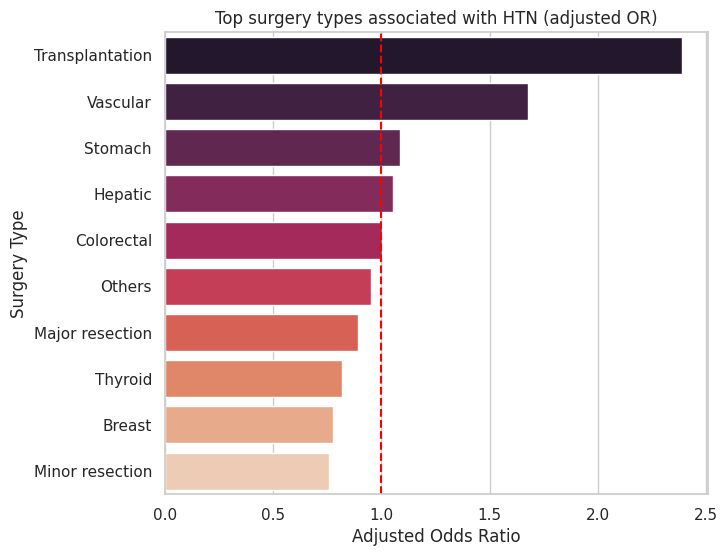

In [32]:
or_df = params_df.copy()
or_df = or_df.reset_index()
or_df = or_df[or_df["index"].str.contains("optype_cat")]
or_df["optype"] = or_df["index"].str.replace("C(optype_cat)[T.", "").str.replace("]", "")

top_or = or_df.sort_values(by="OR", ascending=False).head(10)

plt.figure(figsize=(7,6))
sns.barplot(x='OR', y='optype', data=top_or, palette='rocket')
plt.axvline(1, color='red', linestyle='--')
plt.title("Top surgery types associated with HTN (adjusted OR)")
plt.xlabel("Adjusted Odds Ratio")
plt.ylabel("Surgery Type")
plt.show()

## 3-3. Preoperative metabolic labs vs HTN 분석

### 기초 통계 & 결측률 체크

In [33]:
labs = ["preop_hb", "preop_plt", "preop_pt", "preop_aptt", "preop_gluc"]

df3 = df.copy()

df3[labs].isna().mean()

preop_hb      0.0
preop_plt     0.0
preop_pt      0.0
preop_aptt    0.0
preop_gluc    0.0
dtype: float64

### HTN vs Non-HTN 기초 통계

In [34]:
group_stats = df3.groupby("preop_htn")[labs].describe()
group_stats

preop_hb                                                    \
             count       mean       std  min   25%   50%   75%   max   
preop_htn                                                              
0           4367.0  12.934898  1.892503  3.5  11.9  13.0  14.2  20.2   
1           1964.0  12.697811  1.963039  6.1  11.5  12.9  14.1  18.7   

          preop_plt                                                            \
              count        mean        std   min    25%    50%    75%     max   
preop_htn                                                                       
0            4367.0  242.400733  81.989216   5.0  196.0  235.0  282.0  1156.0   
1            1964.0  239.447556  82.421205  24.0  191.0  235.0  275.0   847.0   

          preop_pt                                                          \
             count        mean        std   min   25%    50%    75%    max   
preop_htn                                                                    
0           4367.0   99.741470  14.487560  14.0  94.0  101.0  107.0  159.0   
1           1964.0  102.614053  14.466422  27.0  96.0  103.0  111.0  153.0   

          preop_aptt                                                        \
               count       mean       std   min   25%   50%     75%    max   
preop_htn                                                                    
0             4367.0  32.956538  9.183292  19.2  30.4  32.1  34.300  400.0   
1             1964.0  32.360489  4.846595  19.9  29.8  31.9  33.925  101.3   

          preop_gluc                                                          
               count        mean        std   min   25%    50%    75%    max  
preop_htn                                                                     
0             4367.0  111.562629  38.314508  44.0  94.0  103.0  115.0  525.0  
1             1964.0  122.524440  45.255047  45.0  98.0  108.0  132.0  511.0

### Mann-Whitney U test (HTN 그룹 비교)

In [ ]:
print("=== Mann-Whitney U test (Labs) ===")
for col in labs:
    x0 = df3[df3.preop_htn==0][col].dropna()
    x1 = df3[df3.preop_htn==1][col].dropna()
    stat, p = mannwhitneyu(x0, x1, alternative='two-sided')
    print(f"{col:15s} p-value = {p:.4g}")

=== Mann-Whitney U test (Labs) ===
preop_hb        p-value = 1.423e-06
preop_plt       p-value = 0.005786
preop_pt        p-value = 4.61e-18
preop_aptt      p-value = 1.025e-08
preop_gluc      p-value = 3.341e-38


### Adjusted Logistic Regression (age, BMI 포함)

In [36]:
# 연속형 lab 변수 표준화(회귀 안정성 향상)
for col in labs:
    df3[f"z_{col}"] = (df3[col] - df3[col].mean()) / df3[col].std()

formula = "preop_htn ~ age + bmi + " + " + ".join([f"z_{col}" for col in labs])
model = smf.logit(formula, data=df3).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.526204
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6323
Method:                           MLE   Df Model:                            7
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.1503
Time:                        14:21:44   Log-Likelihood:                -3331.4
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                3.182e-250
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.7953      0.285    -27.378      0.000      -8.353      -7.237
age              0.0666

### 시각화: HTN vs Non-HTN 분포 비교

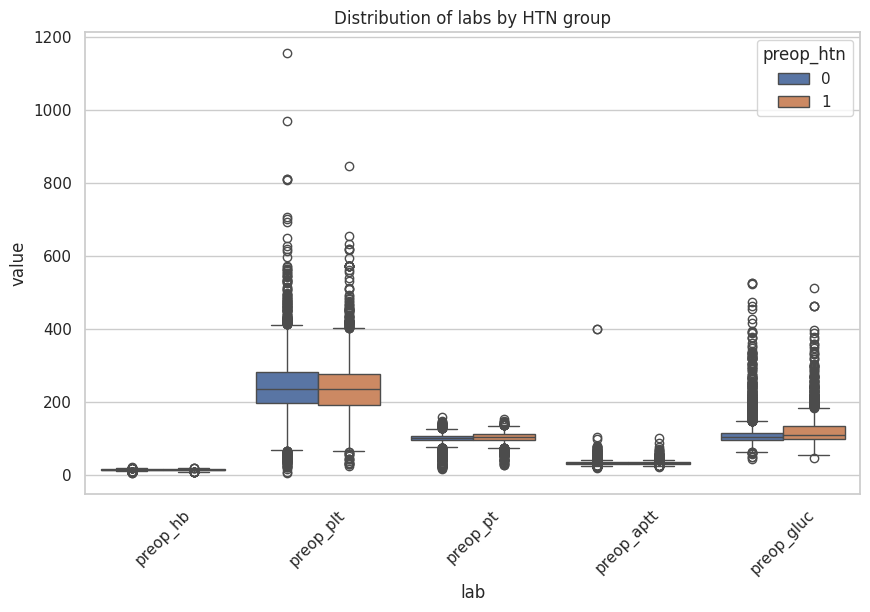

In [38]:
plt.figure(figsize=(10,6))
df3_melt = df3.melt(id_vars="preop_htn", value_vars=labs, var_name="lab", value_name="value")
sns.boxplot(data=df3_melt, x="lab", y="value", hue="preop_htn")
plt.title("Distribution of labs by HTN group")
plt.xticks(rotation=45)
plt.show()

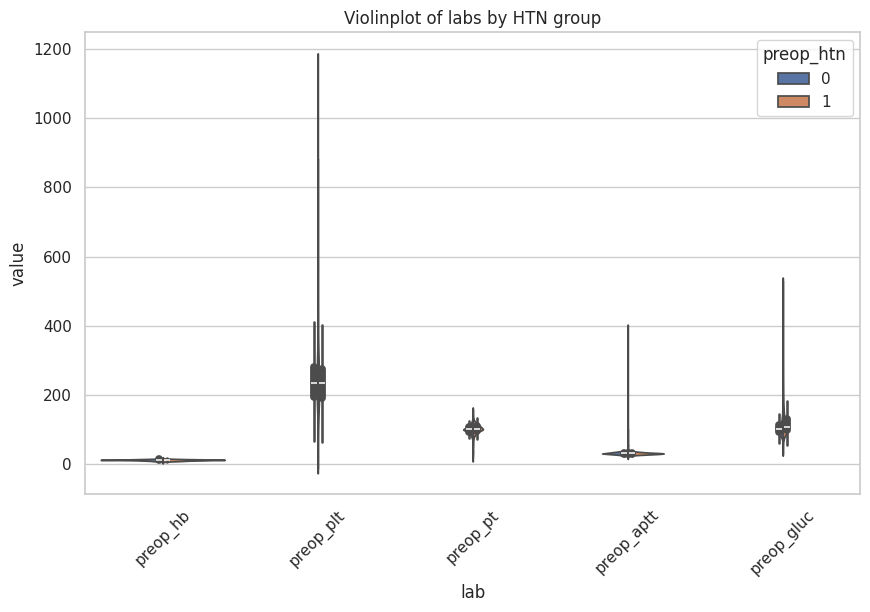

In [39]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df3_melt, x="lab", y="value", hue="preop_htn", split=True)
plt.title("Violinplot of labs by HTN group")
plt.xticks(rotation=45)
plt.show()

## Surgery duration vs HTN (수술 시간 vs 고혈압)
op_duration_min (수술 시간)\
ane_duration_min (마취 시간)

### 기본 통계 요약

In [40]:
dur_cols = ["op_duration_min", "ane_duration_min"]
df4 = df.copy()

df4.groupby("preop_htn")[dur_cols].describe()

op_duration_min                                                 \
                    count        mean         std       min   25%    50%   
preop_htn                                                                  
0                  4367.0  131.927757  100.037531  2.000000  55.0  105.0   
1                  1964.0  143.680898  100.740269  1.416667  65.0  120.0   

                        ane_duration_min                              \
             75%    max            count          mean           std   
preop_htn                                                              
0          180.0  955.0           4367.0    194.934738  1.146312e+02   
1          205.0  705.0           1964.0 -31117.723014  1.388285e+06   

                                                    
                  min    25%    50%    75%     max  
preop_htn                                           
0                16.0  110.0  169.0  254.0  1860.0  
1         -61524471.0  120.0  190.0  279.0   861.0

### Mann-Whitney U Test

In [ ]:
print("=== Mann-Whitney U test: Surgery durations ===")
for col in dur_cols:
    x0 = df4[df4.preop_htn==0][col].dropna()
    x1 = df4[df4.preop_htn==1][col].dropna()
    stat, p = mannwhitneyu(x0, x1, alternative='two-sided')
    print(f"{col:20s} p-value = {p:.4g}")

=== Mann-Whitney U test: Surgery durations ===
op_duration_min      p-value = 2.953e-07
ane_duration_min     p-value = 1.064e-07


### Adjusted Logistic Regression

In [42]:
# 표준화 
for col in dur_cols:
    df4[f"z_{col}"] = (df4[col] - df4[col].mean()) / df4[col].std()

In [43]:
# 회귀
formula = "preop_htn ~ age + bmi + z_op_duration_min + z_ane_duration_min"

model = smf.logit(formula, data=df4).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.530738
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6326
Method:                           MLE   Df Model:                            4
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.1430
Time:                        14:21:45   Log-Likelihood:                -3360.1
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                2.047e-241
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -7.8437      0.287    -27.372      0.000      -8.405      -7.282
age 

### Outlier Cleaning Code

In [44]:
df_clean = df.copy()

# 음수 제거
df_clean = df_clean[df_clean["ane_duration_min"] > 0]

# 상한 기준 설정 (20,000 min = 333 hours = 14 days)
upper_limit = 20000
df_clean = df_clean[df_clean["ane_duration_min"] < upper_limit]

print("Before cleaning:", df["ane_duration_min"].shape[0])
print("After cleaning :", df_clean["ane_duration_min"].shape[0])

print(df_clean["ane_duration_min"].describe())

Before cleaning: 6331
After cleaning : 6330
count    6330.000000
mean      199.137915
std       114.138255
min        16.000000
25%       112.000000
50%       175.000000
75%       260.000000
max      1860.000000
Name: ane_duration_min, dtype: float64


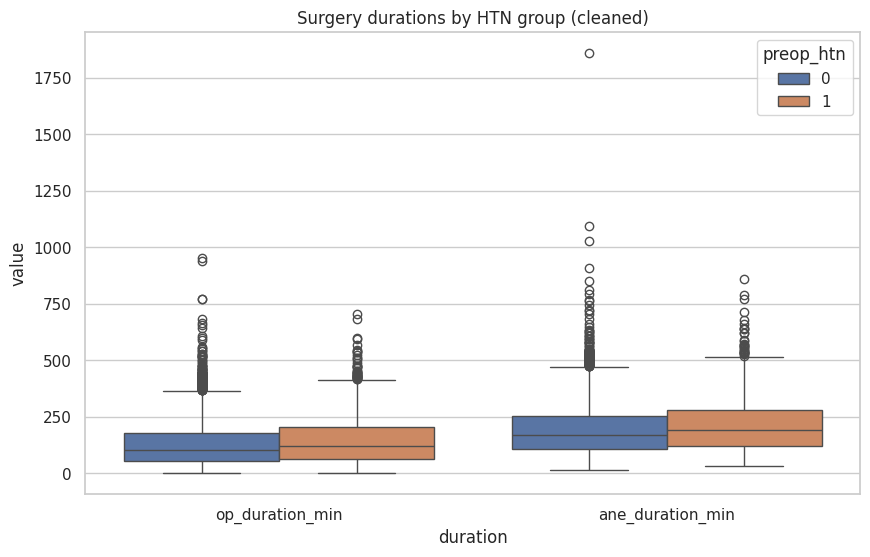

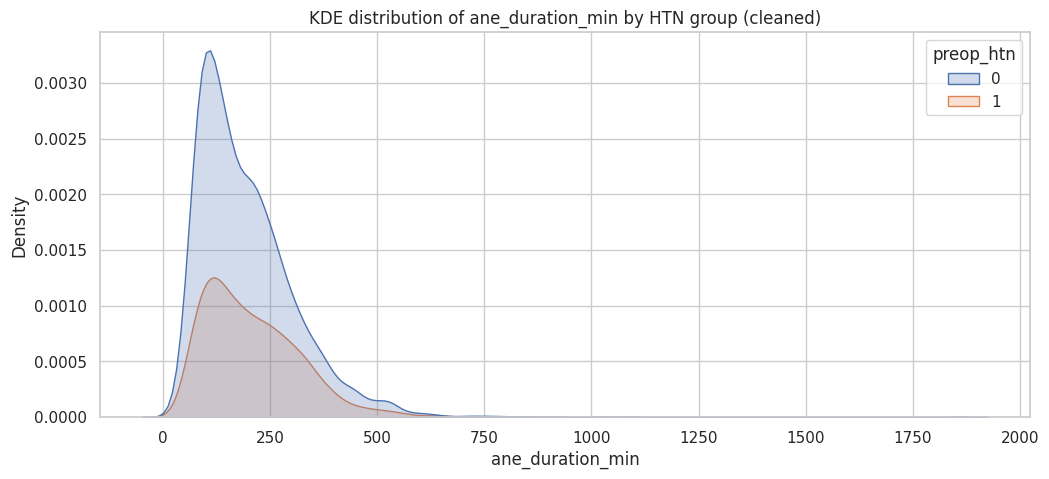

Mann-Whitney U test (ane_duration_min) p = 8.8127e-08
Optimization terminated successfully.
         Current function value: 0.530819
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6330
Model:                          Logit   Df Residuals:                     6326
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.1427
Time:                        14:21:46   Log-Likelihood:                -3360.1
converged:                       True   LL-Null:                       -3919.5
Covariance Type:            nonrobust   LLR p-value:                3.098e-242
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.8440      0.280    -28.010      0.000

In [ ]:

# 시각화 1: boxplot
df_melt = df_clean.melt(
    id_vars=["preop_htn"],
    value_vars=["op_duration_min", "ane_duration_min"],
    var_name="duration",
    value_name="value"
)

plt.figure(figsize=(10,6))
sns.boxplot(data=df_melt, x="duration", y="value", hue="preop_htn")
plt.title("Surgery durations by HTN group (cleaned)")
plt.show()

# 시각화 2: KDE
plt.figure(figsize=(12,5))
sns.kdeplot(
    data=df_clean, x="ane_duration_min",
    hue="preop_htn", fill=True
)
plt.title("KDE distribution of ane_duration_min by HTN group (cleaned)")
plt.show()

# Mann-Whitney U
u_stat, p_val = stats.mannwhitneyu(
    df_clean[df_clean.preop_htn == 0]["ane_duration_min"],
    df_clean[df_clean.preop_htn == 1]["ane_duration_min"]
)
print(f"Mann-Whitney U test (ane_duration_min) p = {p_val:g}")

# 회귀 (age, bmi 보정)
df_clean["z_ane"] = (df_clean["ane_duration_min"] - df_clean["ane_duration_min"].mean()) / df_clean["ane_duration_min"].std()

model = smf.logit("preop_htn ~ age + bmi + z_ane", data=df_clean).fit()
print(model.summary())

### Outcomes 분석 (ICU / 사망)

준비: Outcome 변수 만들기

In [ ]:
df_out = df.copy()

# ICU admission 여부
df_out["icu_admit"] = (df_out["icu_days"] > 0).astype(int)

# 사망 여부
df_out["death_bin"] = (df_out["death_inhosp"] > 0).astype(int)

print("ICU admission rate by HTN:")
print(df_out.groupby("preop_htn")["icu_admit"].mean())

print("\nIn-hospital mortality rate by HTN:")
print(df_out.groupby("preop_htn")["death_bin"].mean())

ICU admission rate by HTN:
preop_htn
0    0.163270
1    0.235234
Name: icu_admit, dtype: float64

In-hospital mortality rate by HTN:
preop_htn
0    0.007557
1    0.009674
Name: death_bin, dtype: float64


### ICU days: 기술통계 + 시각화

ICU days by HTN group:
            count      mean       std  min  25%  50%  75%    max
preop_htn                                                       
0          4367.0  0.419968  3.187879  0.0  0.0  0.0  0.0  179.0
1          1964.0  0.624236  2.916278  0.0  0.0  0.0  0.0   81.0
HTN=0 ICU days 99th percentile: 6.00
HTN=1 ICU days 99th percentile: 11.00


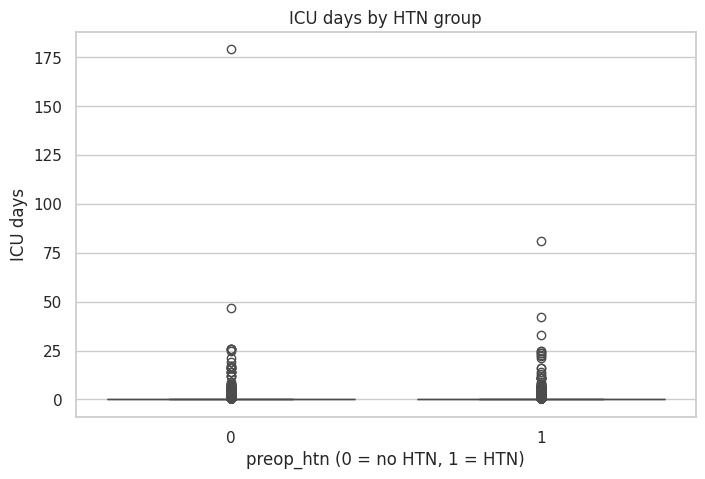

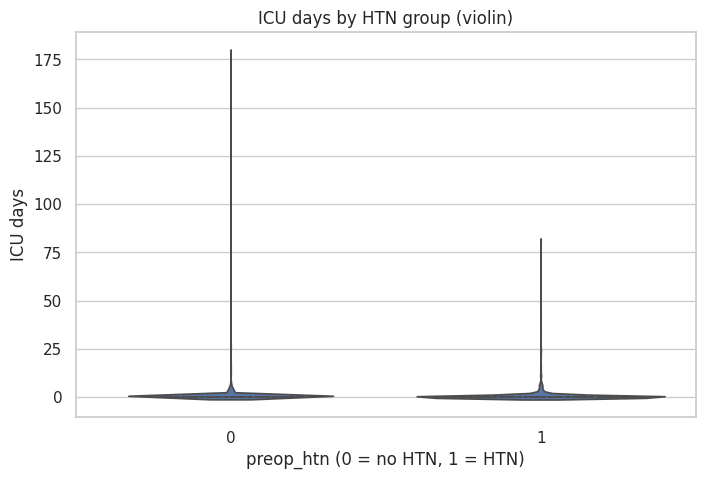

In [47]:
# ICU days 분포 요약 (HTN vs non-HTN)

icu_desc = df_out.groupby("preop_htn")["icu_days"].describe()
print("ICU days by HTN group:")
print(icu_desc)

# 상위 99% 확인

for htn in [0, 1]:
    q99 = df_out.loc[df_out["preop_htn"] == htn, "icu_days"].quantile(0.99)
    print(f"HTN={htn} ICU days 99th percentile: {q99:.2f}")

# Boxplot + Violin plot 

plt.figure(figsize=(8,5))
sns.boxplot(data=df_out, x="preop_htn", y="icu_days")
plt.title("ICU days by HTN group")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(data=df_out, x="preop_htn", y="icu_days", inner="quartile")
plt.title("ICU days by HTN group (violin)")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()


### ICU days: 비모수 검정 (Mann–Whitney U)

In [48]:
# Mann-Whitney U test (ICU days)

icu0 = df_out.loc[df_out["preop_htn"] == 0, "icu_days"].dropna()
icu1 = df_out.loc[df_out["preop_htn"] == 1, "icu_days"].dropna()

u_stat, p_val = stats.mannwhitneyu(icu0, icu1, alternative="two-sided")

print(f"\n[Mann-Whitney U] ICU days by HTN group")
print(f"U-statistic = {u_stat:.0f}, p-value = {p_val:.4e}")


[Mann-Whitney U] ICU days by HTN group
U-statistic = 3983370, p-value = 2.0602e-11


### ICU admission 여부 — 교차표 + χ²

In [49]:
# ICU admission 여부: 교차표 + 카이제곱

ct_icu = pd.crosstab(df_out["preop_htn"], df_out["icu_admit"])
print("\nICU admission cross-tab (rows = HTN, cols = ICU admit)")
print(ct_icu)

chi2, p_chi, dof, _ = stats.chi2_contingency(ct_icu)
print(f"\n[Chi-square] ICU admission vs HTN: chi2={chi2:.2f}, dof={dof}, p={p_chi:.4e}")


ICU admission cross-tab (rows = HTN, cols = ICU admit)
icu_admit     0    1
preop_htn           
0          3654  713
1          1502  462

[Chi-square] ICU admission vs HTN: chi2=45.94, dof=1, p=1.2178e-11


### ICU admission — 다변량 회귀 (Logistic)

남은 행 개수 (회귀 분석용): 6199
=== Check new columns ===
   preop_htn  asa  asa_cat            optype        optype_cat  icu_days  \
0          1  2.0        2        Colorectal        Colorectal         0   
1          0  2.0        2           Stomach           Stomach         0   
2          0  1.0        1  Biliary/Pancreas  Biliary/Pancreas         0   
3          1  2.0        2           Stomach           Stomach         1   
4          1  3.0        3          Vascular          Vascular        13   

   icu_admit  death_inhosp  death_bin  
0          0             0          0  
1          0             0          0  
2          0             0          0  
3          1             0          0  
4          1             0          0  

ICU admission rate by HTN:
preop_htn
0    0.161389
1    0.234504
Name: icu_admit, dtype: float64

In-hospital mortality rate by HTN:
preop_htn
0    0.007506
1    0.009298
Name: death_bin, dtype: float64

=== ICU days by HTN group ===
            count  

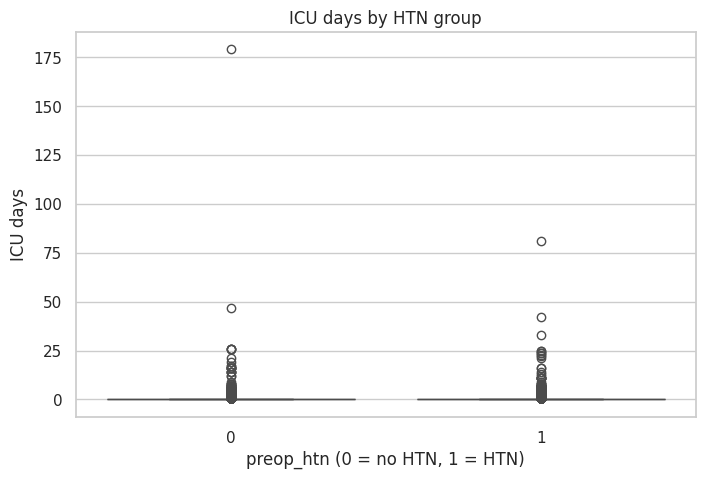

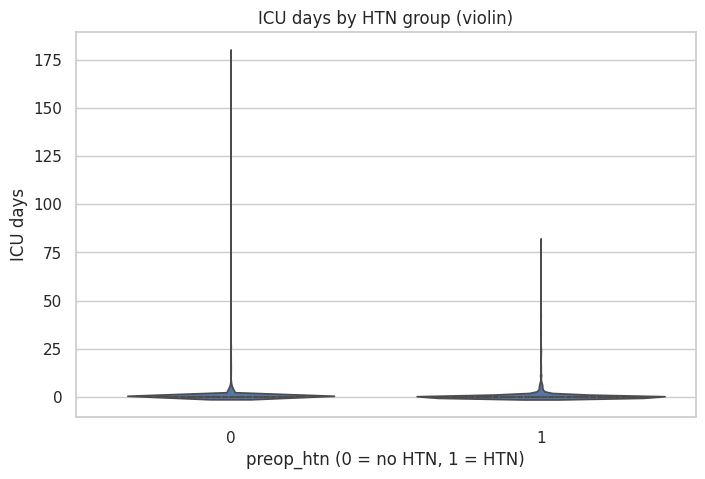


[Mann-Whitney U] ICU days by HTN group
U-statistic = 3828130, p-value = 1.2383e-11

=== ICU admission cross-tab (rows=HTN, cols=ICU admit) ===
icu_admit     0    1
preop_htn           
0          3575  688
1          1482  454

[Chi-square] ICU admission vs HTN: chi2=46.87, dof=1, p=7.5715e-12
Optimization terminated successfully.
         Current function value: 0.344776
         Iterations 10

=== Logistic regression: ICU admission ===
                           Logit Regression Results                           
Dep. Variable:              icu_admit   No. Observations:                 6199
Model:                          Logit   Df Residuals:                     6181
Method:                           MLE   Df Model:                           17
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.2783
Time:                        14:21:47   Log-Likelihood:                -2137.3
converged:                       True   LL-Null:                       -2961.5
Cova

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nakyung/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:

# Outcomes 분석 (ICU / Mortality)

sns.set(style="whitegrid")

# 분석용 데이터셋 복사 + 기본 파생변수 생성

df_out = df.copy()

# (1) ICU 입실 여부: icu_days > 0
df_out["icu_admit"] = (df_out["icu_days"] > 0).astype(int)

# (2) 병원 내 사망 여부: death_inhosp > 0
df_out["death_bin"] = (df_out["death_inhosp"] > 0).astype(int)

# 회귀에 필요한 최소 컬럼이 모두 있는 행만 사용

cols_needed = ["preop_htn", "age", "bmi", "asa", "optype",
               "icu_days", "icu_admit", "death_inhosp", "death_bin"]
df_out = df_out.dropna(subset=["preop_htn", "age", "bmi", "asa", "optype"]).copy()

print("남은 행 개수 (회귀 분석용):", len(df_out))

# (3) ASA 카테고리 (1,2,3,4,6) -> 정수형 카테고리
df_out["asa_cat"] = df_out["asa"].round().astype(int)

# (4) 수술 유형 카테고리
op_map = {
    "Biliary/Pancreas": "Biliary/Pancreas",
    "Breast": "Breast",
    "Colorectal": "Colorectal",
    "Hepatic": "Hepatic",
    "Major resection": "Major resection",
    "Minor resection": "Minor resection",
    "Others": "Others",
    "Stomach": "Stomach",
    "Thyroid": "Thyroid",
    "Transplantation": "Transplantation",
    "Vascular": "Vascular",
}
df_out["optype_cat"] = df_out["optype"].map(op_map)

print("=== Check new columns ===")
print(df_out[["preop_htn", "asa", "asa_cat", "optype", "optype_cat",
              "icu_days", "icu_admit", "death_inhosp", "death_bin"]].head())

print("\nICU admission rate by HTN:")
print(df_out.groupby("preop_htn")["icu_admit"].mean())

print("\nIn-hospital mortality rate by HTN:")
print(df_out.groupby("preop_htn")["death_bin"].mean())

# ICU days: 기술통계 + 시각화
icu_desc = df_out.groupby("preop_htn")["icu_days"].describe()
print("\n=== ICU days by HTN group ===")
print(icu_desc)

for htn in [0, 1]:
    q99 = df_out.loc[df_out["preop_htn"] == htn, "icu_days"].quantile(0.99)
    print(f"HTN={htn} ICU days 99th percentile: {q99:.2f}")

plt.figure(figsize=(8,5))
sns.boxplot(data=df_out, x="preop_htn", y="icu_days")
plt.title("ICU days by HTN group")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(data=df_out, x="preop_htn", y="icu_days", inner="quartile")
plt.title("ICU days by HTN group (violin)")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()

# ICU days: Mann–Whitney U test
icu0 = df_out.loc[df_out["preop_htn"] == 0, "icu_days"].dropna()
icu1 = df_out.loc[df_out["preop_htn"] == 1, "icu_days"].dropna()

u_stat, p_val = stats.mannwhitneyu(icu0, icu1, alternative="two-sided")
print(f"\n[Mann-Whitney U] ICU days by HTN group")
print(f"U-statistic = {u_stat:.0f}, p-value = {p_val:.4e}")

# ICU admission 여부: 교차표 + 카이제곱
ct_icu = pd.crosstab(df_out["preop_htn"], df_out["icu_admit"])
print("\n=== ICU admission cross-tab (rows=HTN, cols=ICU admit) ===")
print(ct_icu)

chi2, p_chi, dof, _ = stats.chi2_contingency(ct_icu)
print(f"\n[Chi-square] ICU admission vs HTN: chi2={chi2:.2f}, dof={dof}, p={p_chi:.4e}")

# ICU admission Logit: HTN + age + BMI + ASA + Optype
formula_icu = "icu_admit ~ preop_htn + age + bmi + C(asa_cat) + C(optype_cat)"

model_icu = smf.logit(formula_icu, data=df_out).fit()
print("\n=== Logistic regression: ICU admission ===")
print(model_icu.summary())

params_icu = model_icu.params
conf_icu = model_icu.conf_int()
or_icu = pd.DataFrame({
    "coef": params_icu,
    "OR": np.exp(params_icu),
    "OR_low": np.exp(conf_icu[0]),
    "OR_high": np.exp(conf_icu[1]),
    "p_value": model_icu.pvalues,
})
print("\n=== Adjusted OR for ICU admission ===")
print(or_icu.sort_values("OR", ascending=False).head(20))

# In-hospital mortality: 교차표 + 카이제곱
ct_death = pd.crosstab(df_out["preop_htn"], df_out["death_bin"])
print("\n=== In-hospital mortality cross-tab (rows=HTN, cols=death) ===")
print(ct_death)

chi2_d, p_d, dof_d, _ = stats.chi2_contingency(ct_death)
print(f"\n[Chi-square] Mortality vs HTN: chi2={chi2_d:.2f}, dof={dof_d}, p={p_d:.4e}")

# Mortality Logit: HTN + age + BMI + ASA + Optype
formula_death = "death_bin ~ preop_htn + age + bmi + C(asa_cat) + C(optype_cat)"

model_death = smf.logit(formula_death, data=df_out).fit()
print("\n=== Logistic regression: In-hospital mortality ===")
print(model_death.summary())

params_d = model_death.params
conf_d = model_death.conf_int()
or_death = pd.DataFrame({
    "coef": params_d,
    "OR": np.exp(params_d),
    "OR_low": np.exp(conf_d[0]),
    "OR_high": np.exp(conf_d[1]),
    "p_value": model_death.pvalues,
})
print("\n=== Adjusted OR for in-hospital mortality ===")
print(or_death.sort_values("OR", ascending=False).head(20))


---

# **4. 고혈압 예측 모델**

Numeric features: ['age', 'bmi', 'asa', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc']
Categorical features: ['sex', 'department', 'optype', 'emop', 'preop_dm']
X shape: (6331, 15) | y distribution:
preop_htn
0    0.68978
1    0.31022
Name: proportion, dtype: float64
=== Classification report (Test set) ===
              precision    recall  f1-score   support

           0      0.864     0.683     0.763       874
           1      0.519     0.761     0.617       393

    accuracy                          0.707      1267
   macro avg      0.692     0.722     0.690      1267
weighted avg      0.757     0.707     0.718      1267

ROC-AUC (test): 0.8027524004169068


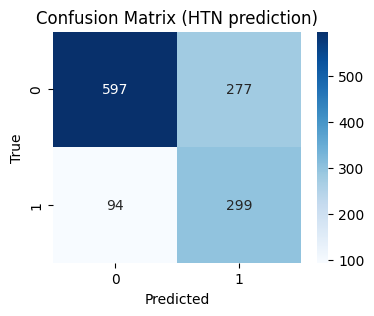

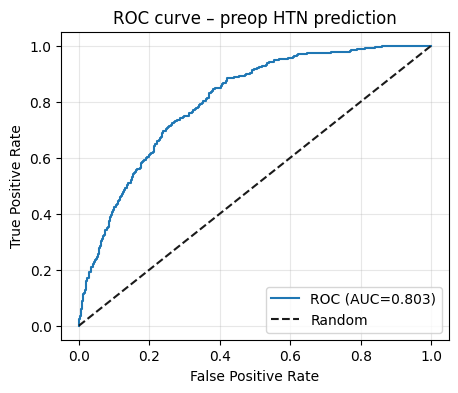

5-fold CV ROC-AUC: [0.80960283 0.80353494 0.82004669 0.77894657 0.80166546]
5-fold CV ROC-AUC mean ± std: 0.803 ± 0.014

=== Top 15 features by odds ratio (HTN↑) ===
                       feature      coef  odds_ratio
0                          age  0.922304    2.515080
2                          asa  0.836120    2.307398
1                          bmi  0.519688    1.681504
25      optype_Transplantation  0.452569    1.572347
12  department_General surgery  0.305076    1.356728
5                     preop_pt  0.266732    1.305691
20      optype_Major resection  0.187784    1.206573
23              optype_Stomach  0.172221    1.187941
26             optype_Vascular  0.149551    1.161312
4                    preop_plt  0.142608    1.153278
30                  preop_dm_1  0.090528    1.094752
28                      emop_1  0.051575    1.052928
3                     preop_hb  0.017005    1.017150
6                   preop_aptt  0.013976    1.014074
8                      preop_k -0.00393

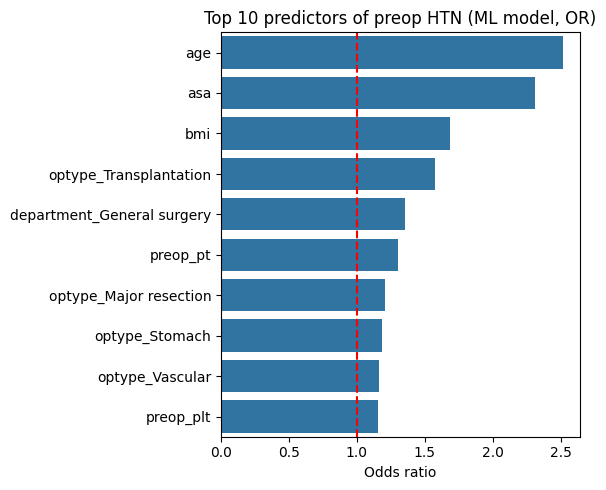

In [ ]:

# Preoperative HTN Prediction Model (scikit-learn)

plt.style.use("default")

# Feature / Target 정의

# 타겟: preop_htn (0/1)
target_col = "preop_htn"

numeric_features = [
    "age", "bmi", "asa",
    "preop_hb", "preop_plt",
    "preop_pt", "preop_aptt",
    "preop_na", "preop_k", "preop_gluc"
]

categorical_features = [
    "sex",         # M/F
    "department",  # 수술 과
    "optype",      # 수술 유형
    "emop",        # 응급 수술 여부 (0/1)
    "preop_dm"     # 당뇨 동반 여부 (0/1)
]

print("Numeric features:", [c for c in numeric_features if c in df.columns])
print("Categorical features:", [c for c in categorical_features if c in df.columns])

X = df[numeric_features + categorical_features].copy()
y = df[target_col].astype(int)

print("X shape:", X.shape, "| y distribution:")
print(y.value_counts(normalize=True))

# Train/Test split
#   - stratify=y : HTN 비율 유지

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Preprocessing pipeline 설정

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 최종 파이프라인 (Logistic Regression 모델)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# 모델 학습

clf.fit(X_train, y_train)

# 테스트셋 평가

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("=== Classification report (Test set) ===")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC (test):", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (HTN prediction)")
plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – preop HTN prediction")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 5-fold Cross-validation (ROC-AUC)

cv_scores = cross_val_score(
    clf, X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
print("5-fold CV ROC-AUC:", cv_scores)
print("5-fold CV ROC-AUC mean ± std: "
      f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 1) 학습된 모델 & 인코더 꺼내기
logit_model = clf.named_steps["model"]
ct = clf.named_steps["preprocess"]

# 2) OneHotEncoder에서 범주형 이름 가져오기
ohe = ct.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# 3) 최종 feature 이름
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# 4) 계수, OR 계산
coef = logit_model.coef_[0]
or_vals = np.exp(coef)

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coef,
    "odds_ratio": or_vals
}).sort_values("odds_ratio", ascending=False)

print("\n=== Top 15 features by odds ratio (HTN↑) ===")
print(coef_df.head(15))

print("\n=== Bottom 15 features by odds ratio (HTN↓ 보호요인) ===")
print(coef_df.tail(15))

# 간단 시각화
top_n = 10
plt.figure(figsize=(6, 5))
sns.barplot(
    data=coef_df.head(top_n),
    x="odds_ratio",
    y="feature",
    orient="h"
)
plt.axvline(1.0, color="red", linestyle="--")
plt.title(f"Top {top_n} predictors of preop HTN (ML model, OR)")
plt.xlabel("Odds ratio")
plt.ylabel("")
plt.tight_layout()
plt.show()


## 여러 모델 비교

In [ ]:
# Data split

target = "preop_htn"

numeric_features = ['age', 'bmi', 'asa',
                    'preop_hb', 'preop_plt', 'preop_pt',
                    'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc']

categorical_features = ['sex', 'department', 'optype', 'emop', 'preop_dm']

X = df[numeric_features + categorical_features].copy()
y = df[target].astype(int)

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Preprocessor

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Models

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, 
        min_samples_split=5, 
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=-1, random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=300, max_depth=3,
        random_state=42
    ),
    "SVM_RBF": SVC(
        kernel="rbf", C=1.0, gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=42
    )
}

# CV + tqdm

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

print("\n=== Running cross-validation with tqdm ===\n")

for name, model in models.items():
    print(f"▶ Model: {name}")
    
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", model)
    ])
    
    fold_auc = []
    for fold, (tr_idx, val_idx) in enumerate(tqdm(cv.split(X_train, y_train), total=5)):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        y_proba = pipe.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_proba)
        fold_auc.append(auc)

    print(f"  AUC (mean ± std): {np.mean(fold_auc):.4f} ± {np.std(fold_auc):.4f}\n")

    cv_results.append({
        "model": name,
        "auc_mean": np.mean(fold_auc),
        "auc_std": np.std(fold_auc)
    })

cv_df = pd.DataFrame(cv_results).sort_values("auc_mean", ascending=False)

print("\n=== CV Results ===")
print(cv_df)


X shape: (6331, 15)
y distribution:
preop_htn
0    0.68978
1    0.31022
Name: proportion, dtype: float64

=== Running cross-validation with tqdm ===

▶ Model: LogReg


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8000 ± 0.0079

▶ Model: RandomForest


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8061 ± 0.0098

▶ Model: GradientBoosting


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8117 ± 0.0071

▶ Model: SVM_RBF


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8032 ± 0.0095


=== CV Results ===
              model  auc_mean   auc_std
2  GradientBoosting  0.811702  0.007144
1      RandomForest  0.806071  0.009761
3           SVM_RBF  0.803198  0.009458
0            LogReg  0.800041  0.007865


>>> Best model by CV AUC: GradientBoosting



=== Test set performance (Best model) ===
              precision    recall  f1-score   support

           0      0.796     0.835     0.815       874
           1      0.589     0.524     0.555       393

    accuracy                          0.739      1267
   macro avg      0.692     0.680     0.685      1267
weighted avg      0.732     0.739     0.734      1267

Test ROC-AUC: 0.8118009095090863


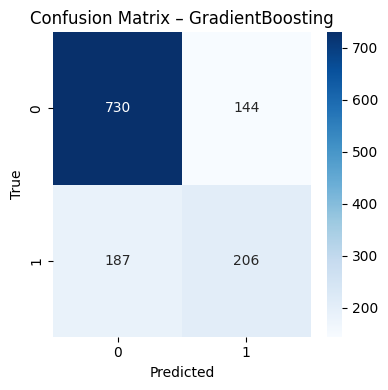

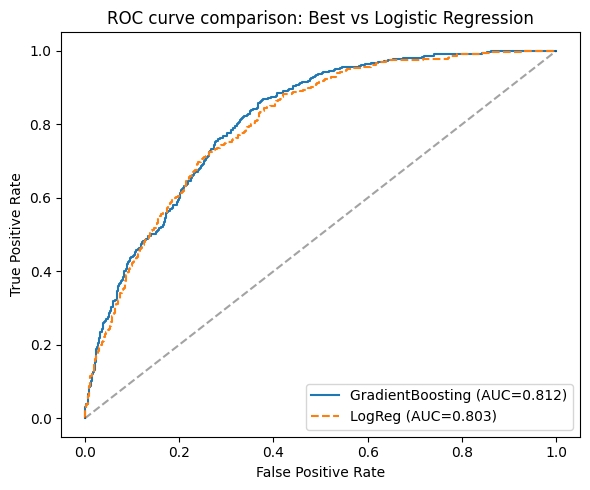

In [53]:

# 1. Best model 선정

best_name = cv_df.iloc[0]["model"]
print(f">>> Best model by CV AUC: {best_name}")

best_clf = models[best_name]

best_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", best_clf)
])

# train 데이터 전체로 다시 학습
best_pipe.fit(X_train, y_train)

# test set 예측
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("\n=== Test set performance (Best model) ===")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_name}")
plt.tight_layout()
plt.show()

# ROC curve 비교 (Best vs LogReg)
logreg_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", models["LogReg"])
])
logreg_pipe.fit(X_train, y_train)
y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]

fpr_best, tpr_best, _ = roc_curve(y_test, y_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(6,5))
plt.plot(fpr_best, tpr_best, label=f"{best_name} (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_score(y_test, y_proba_lr):.3f})", linestyle="--")
plt.plot([0,1], [0,1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve comparison: Best vs Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()



=== Top 15 feature importances (GradientBoosting) ===
                       feature  importance
2                          asa    0.308747
0                          age    0.263842
1                          bmi    0.111945
5                     preop_pt    0.058898
4                    preop_plt    0.046816
8                      preop_k    0.039701
9                   preop_gluc    0.034101
3                     preop_hb    0.031298
6                   preop_aptt    0.024238
7                     preop_na    0.018002
25      optype_Transplantation    0.011703
12  department_General surgery    0.008031
29                  preop_dm_0    0.007365
10                       sex_F    0.006096
30                  preop_dm_1    0.005400


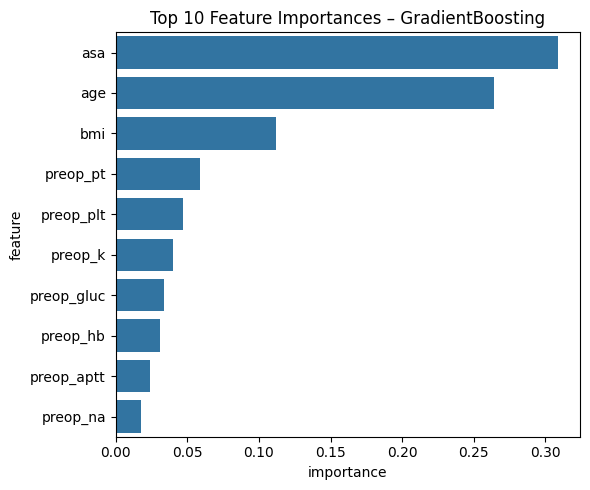

In [54]:

# 2. Feature importance (GradientBoosting 전용)

gb_model = best_pipe.named_steps["clf"]
ct = best_pipe.named_steps["preprocess"]

# OneHotEncoder에서 최종 피처 이름 뽑기
ohe = ct.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = gb_model.feature_importances_
fi = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\n=== Top 15 feature importances (GradientBoosting) ===")
print(fi.head(15))

plt.figure(figsize=(6,5))
sns.barplot(data=fi.head(10), x="importance", y="feature", orient="h")
plt.title("Top 10 Feature Importances – GradientBoosting")
plt.tight_layout()
plt.show()


In [55]:
ct = best_pipe.named_steps["preprocess"]

ohe = ct.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])
len(all_feature_names)


31

In [ ]:
# tree explainer
explainer = shap.TreeExplainer(best_clf)

In [57]:
best_clf = best_pipe.named_steps["clf"]

In [58]:
X_test_transformed = ct.transform(X_test)

# SHAP values 계산
shap_values = explainer.shap_values(X_test_transformed)

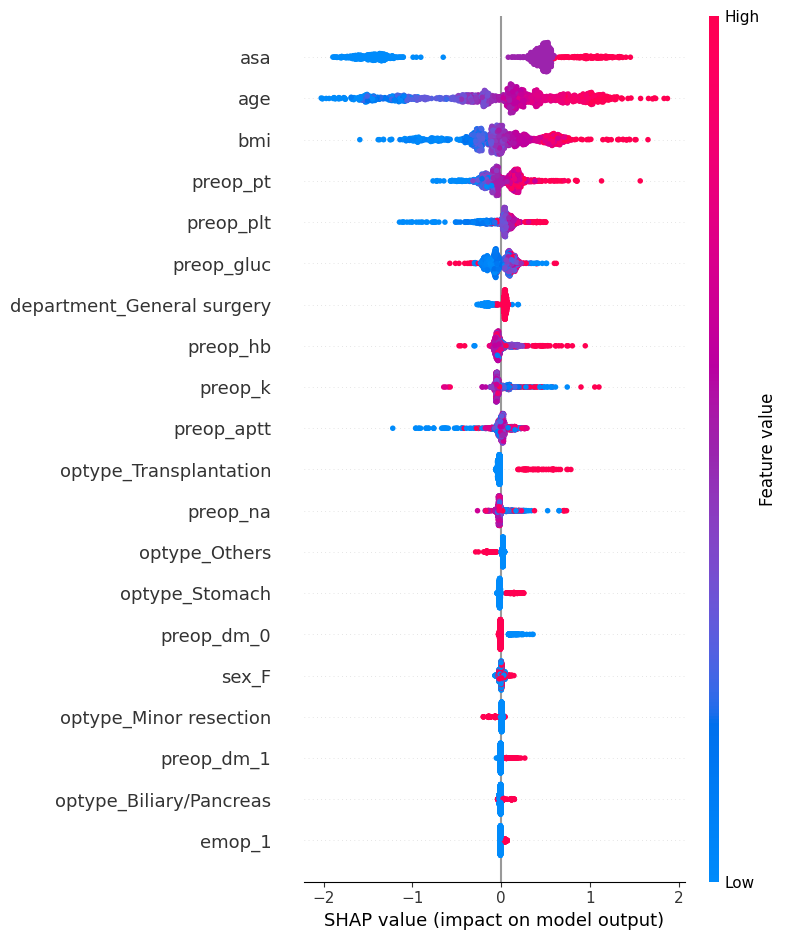

In [59]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=all_feature_names,
    plot_type="dot"
)

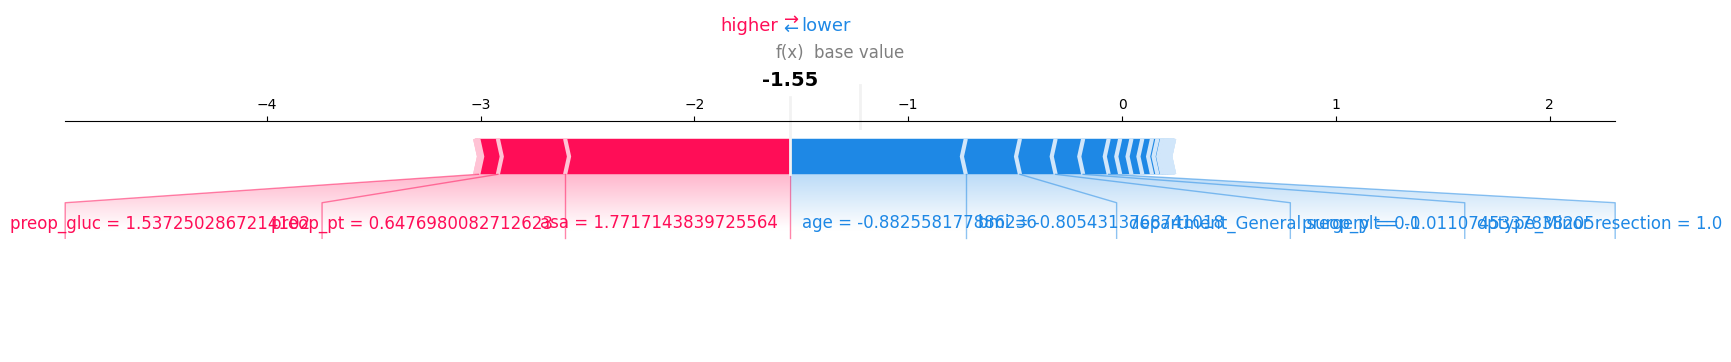

In [60]:
# test sample 활용 설명 
i = 10  # 10번째 test sample
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_test_transformed[i, :],
    feature_names=all_feature_names,
    matplotlib=True
)


총 feature 수: 31
SHAP values shape: (1267, 31)


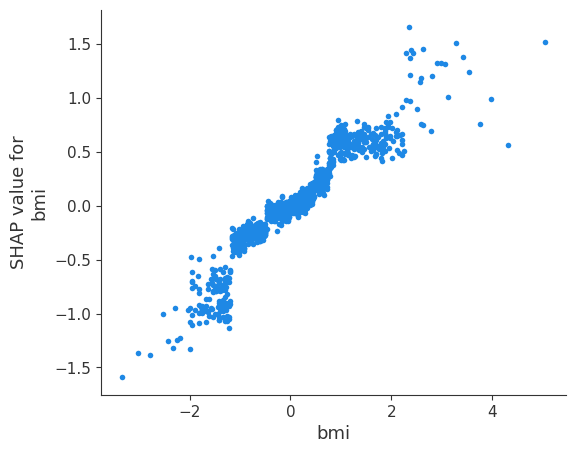

In [61]:
# 1) Pipeline 구성 요소 가져오기
preprocessor = best_pipe.named_steps["preprocess"]
best_clf = best_pipe.named_steps["clf"]     # GradientBoostingClassifier

# 2) Feature 이름 구성
# OHE categorical 이름
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# numeric + categorical 전체 이름
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

print("총 feature 수:", len(all_feature_names))

# 3) Test 데이터를 preprocessor로 변환
X_test_transformed = preprocessor.transform(X_test)

# 4) SHAP Explainer 생성
explainer = shap.TreeExplainer(best_clf)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test_transformed)

print("SHAP values shape:", shap_values.shape)

# 5) Dependence Plot (BMI 기준)
shap.dependence_plot(
    "bmi",
    shap_values,
    X_test_transformed,
    feature_names=all_feature_names,
    interaction_index=None
)

In [ ]:
# SHAP Dependence Plot – Top 10 Features 자동 생성 코드

# 1) Preprocessor + Model 불러오기
preprocessor = best_pipe.named_steps["preprocess"]
best_clf = best_pipe.named_steps["clf"]

# 2) 전체 feature 이름 구성
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

print("전체 Feature 수 =", len(all_feature_names))

# 3) Test 데이터 변환
X_test_transformed = preprocessor.transform(X_test)

# 4) SHAP explainer 생성
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test_transformed)

# 5) Feature importance (mean |SHAP|) 계산 → Top 10 선정
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[::-1][:10]
top_features = [all_feature_names[i] for i in top_idx]

print("Top 10 SHAP 중요 Feature:")
for f in top_features:
    print("  -", f)

# 6) Dependence Plot 자동 생성
os.makedirs("shap_dependence_plots", exist_ok=True)

for feature_name in top_features:
    print(f"\nPlotting dependence for: {feature_name}")

    plt.figure(figsize=(6,4))
    shap.dependence_plot(
        feature_name,
        shap_values,
        X_test_transformed,
        feature_names=all_feature_names,
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {feature_name}")
    plt.tight_layout()
    plt.savefig(f"shap_dependence_plots/{feature_name}_dependence.png", dpi=150)
    plt.close()

print("\n모든 SHAP dependence plot 저장됨 → shap_dependence_plots/ 폴더")


전체 Feature 수 = 31


Top 10 SHAP 중요 Feature:
  - asa
  - age
  - bmi
  - preop_pt
  - preop_plt
  - preop_gluc
  - department_General surgery
  - preop_hb
  - preop_k
  - preop_aptt

Plotting dependence for: asa

Plotting dependence for: age

Plotting dependence for: bmi

Plotting dependence for: preop_pt

Plotting dependence for: preop_plt

Plotting dependence for: preop_gluc

Plotting dependence for: department_General surgery

Plotting dependence for: preop_hb

Plotting dependence for: preop_k

Plotting dependence for: preop_aptt

모든 SHAP dependence plot 저장됨 → shap_dependence_plots/ 폴더


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>


=== SHAP dependence: asa ===


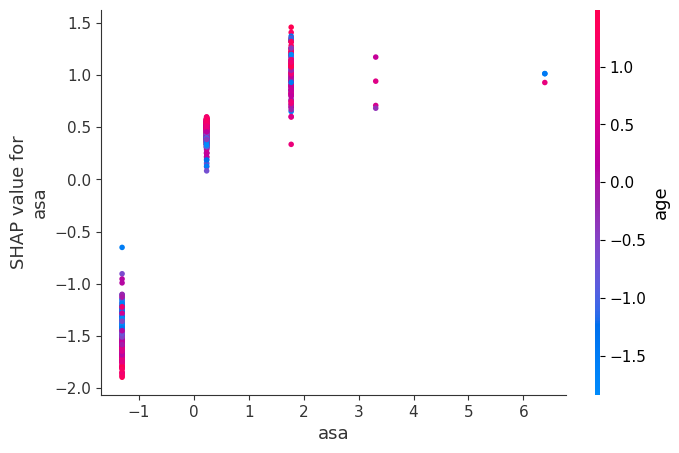


=== SHAP dependence: age ===


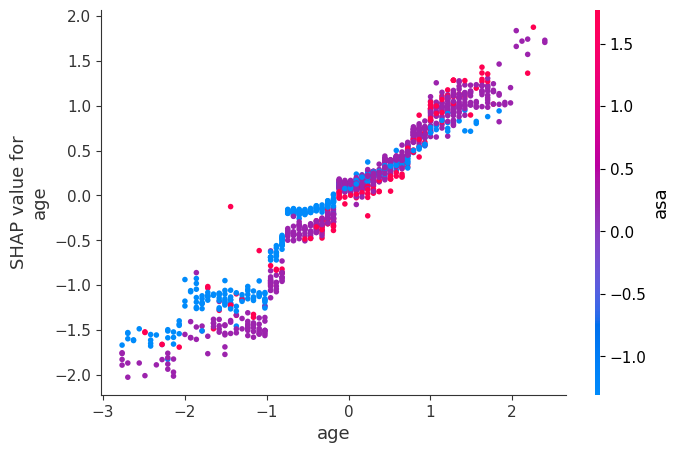


=== SHAP dependence: bmi ===


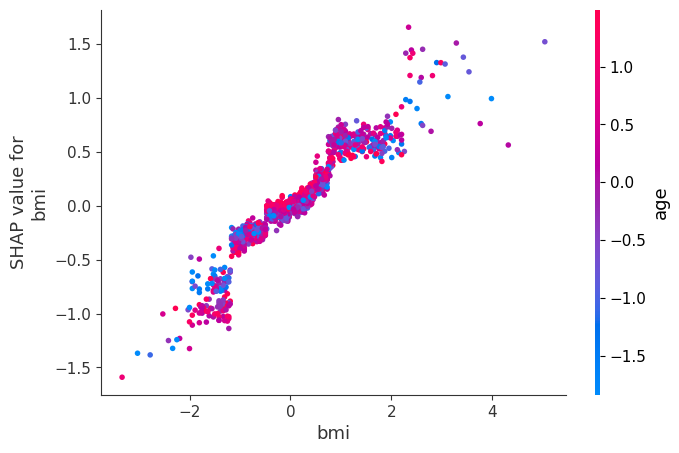


=== SHAP dependence: preop_pt ===


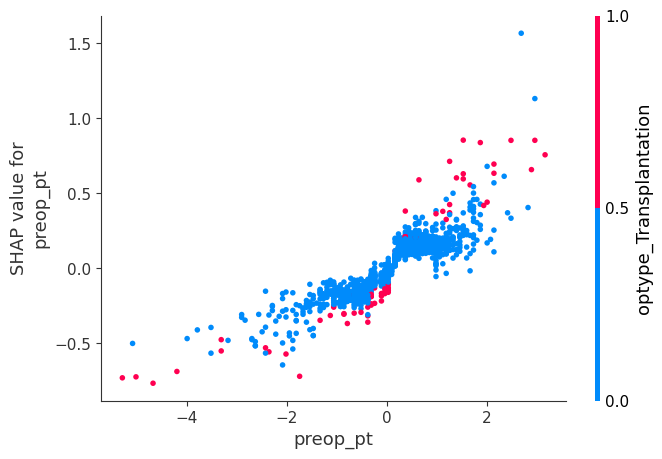


=== SHAP dependence: preop_plt ===


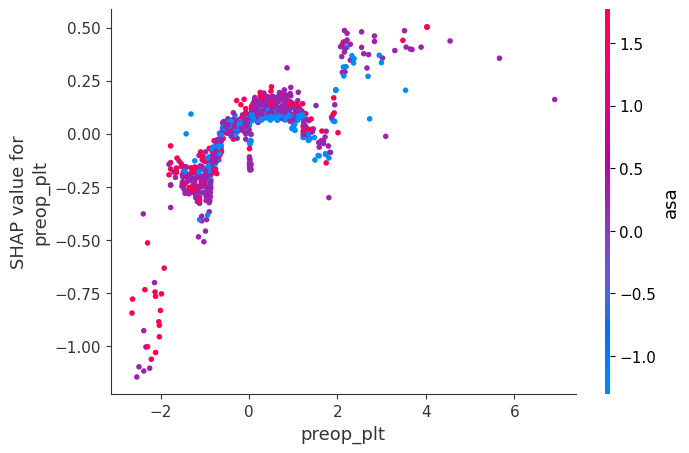


=== SHAP dependence: preop_gluc ===


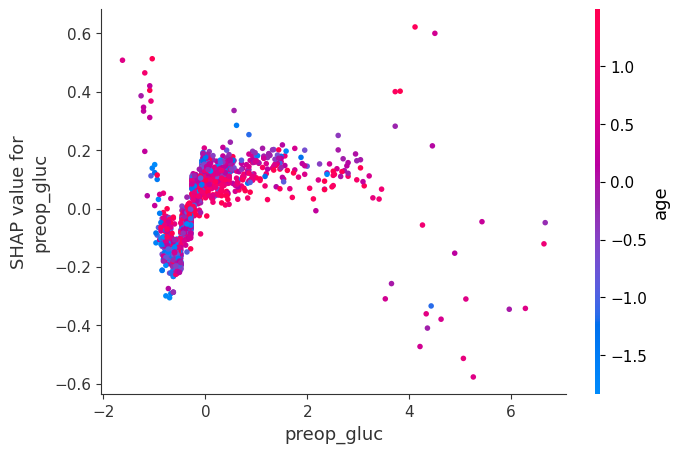


=== SHAP dependence: department_General surgery ===


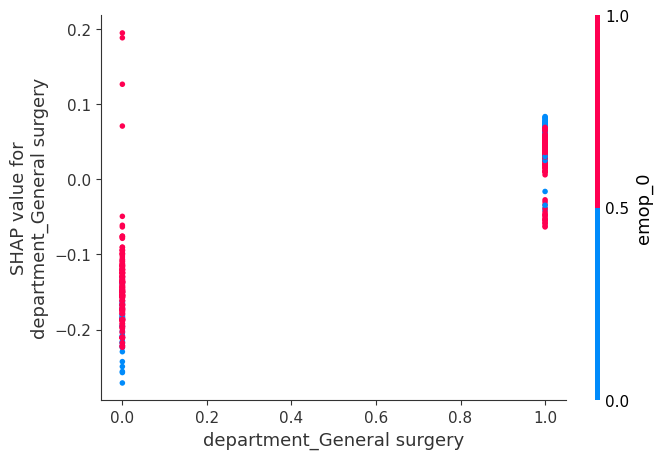


=== SHAP dependence: preop_hb ===


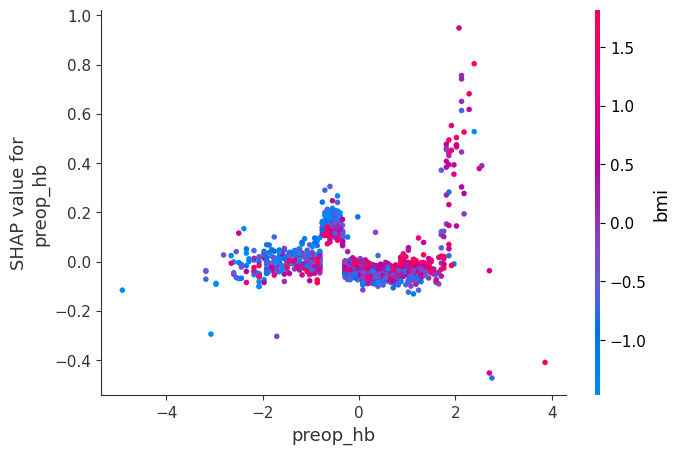


=== SHAP dependence: preop_k ===


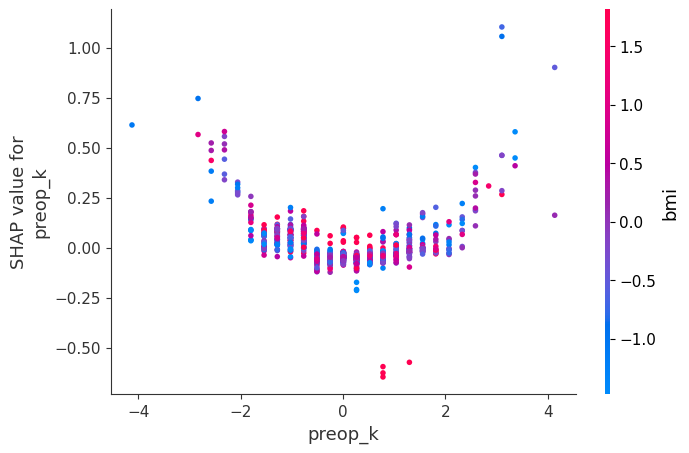


=== SHAP dependence: preop_aptt ===


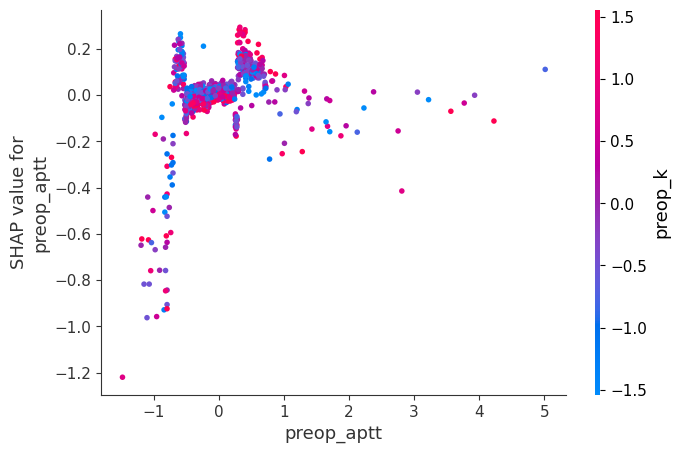

In [63]:
preprocessor = best_pipe.named_steps["preprocess"]
best_clf = best_pipe.named_steps["clf"]

ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

X_test_transformed = preprocessor.transform(X_test)

explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test_transformed)

shap.initjs()

important_features = [
    "asa",
    "age",
    "bmi",
    "preop_pt",
    "preop_plt",
    "preop_gluc",
    "department_General surgery",
    "preop_hb",
    "preop_k",
    "preop_aptt",
]

for f in important_features:
    print(f"\n=== SHAP dependence: {f} ===")
    shap.dependence_plot(
        f,
        shap_values,
        X_test_transformed,
        feature_names=all_feature_names,
    )


---

# **5. Clustering & UMAP & Cluster별 SHAP**

## 1) Gower Distance 계산 코드

In [ ]:
# 1) 클러스터링 컬럼만 추출
cluster_features = [
    "age", "bmi", "asa",
    "preop_hb", "preop_plt", "preop_pt", "preop_aptt",
    "preop_gluc",
    "sex", "department", "optype", 
    "preop_dm", "emop"
]

df_cluster = df[cluster_features].copy()

# 2) Numeric / Categorical 분리
num_cols = df_cluster.select_dtypes(include=['float64','int64']).columns
cat_cols = df_cluster.select_dtypes(include=['object','category']).columns

# 3) NA 처리
# numeric → median
df_cluster[num_cols] = df_cluster[num_cols].fillna(df_cluster[num_cols].median())

# categorical → most common
df_cluster[cat_cols] = df_cluster[cat_cols].fillna(df_cluster[cat_cols].mode().iloc[0])

print("결측 처리 완료")
print(df_cluster.isna().sum())

결측 처리 완료
age           0
bmi           0
asa           0
preop_hb      0
preop_plt     0
preop_pt      0
preop_aptt    0
preop_gluc    0
sex           0
department    0
optype        0
preop_dm      0
emop          0
dtype: int64


In [65]:
gower_dist = gower.gower_matrix(df_cluster)

print("Gower distance shape:", gower_dist.shape)
print("NaN in gower_dist?", np.isnan(gower_dist).sum())

Gower distance shape: (6331, 6331)
NaN in gower_dist? 0


## 2) 최적 클러스터 수(k) 탐색

In [66]:
range_k = [2,3,4,5,6]
scores = {}

for k in range_k:
    model = AgglomerativeClustering(
        n_clusters=k,
        metric='precomputed',
        linkage='average'
    )
    labels = model.fit_predict(gower_dist)

    sil = silhouette_score(gower_dist, labels, metric="precomputed")
    scores[k] = sil
    print(f"k={k}, Silhouette={sil:.4f}")

best_k = max(scores, key=scores.get)
print("\nBest k =", best_k)


k=2, Silhouette=0.4676
k=3, Silhouette=0.2758
k=4, Silhouette=0.2967
k=5, Silhouette=0.2879
k=6, Silhouette=0.2848

Best k = 2


## 3) 최종 클러스터링 실행

In [67]:
best_model = AgglomerativeClustering(
    n_clusters=best_k,
    metric='precomputed',
    linkage='average'
)

cluster_labels = best_model.fit_predict(gower_dist)
df_cluster["cluster"] = cluster_labels


## 4) 클러스터별 HTN 비율·ASA·나이·BMI 비교

In [68]:
df_cluster["preop_htn"] = df["preop_htn"].values

# HTN 비율
print(df_cluster.groupby("cluster")["preop_htn"].mean())



cluster
0    0.310416
1    0.000000
Name: preop_htn, dtype: float64


In [ ]:
# 1) 숫자형 컬럼만 사용 
num_cols = df_cluster.select_dtypes(include=[np.number]).columns.tolist()

# cluster 컬럼 제외한 feature들만
num_feature_cols = [c for c in num_cols if c != "cluster"]

# 2) 클러스터별 평균 계산 (열=cluster, 행=feature가 되게 transpose)
means = df_cluster.groupby("cluster")[num_feature_cols].mean().T

col0, col1 = means.columns[0], means.columns[1]

# 3) 평균 차이(abs) 열 추가
means["diff_abs"] = (means[col0] - means[col1]).abs()

# 4) 차이 큰 순으로 정렬
means_sorted = means.sort_values("diff_abs", ascending=False)

means_sorted

cluster              0        1    diff_abs
preop_aptt   32.645077  232.950  200.304923
preop_plt   241.595227   66.500  175.095227
preop_pt    100.679627   26.250   74.429627
preop_gluc  114.939940  151.750   36.810060
age          57.729730   49.000    8.729730
preop_hb     12.865892    5.675    7.190892
bmi          23.320847   18.475    4.845847
asa           1.844792    3.250    1.405208
preop_dm      0.103841    1.000    0.896159
emop          0.119488    1.000    0.880512
preop_htn     0.310416    0.000    0.310416

## 5) 시각화: Radar plot or profile plot

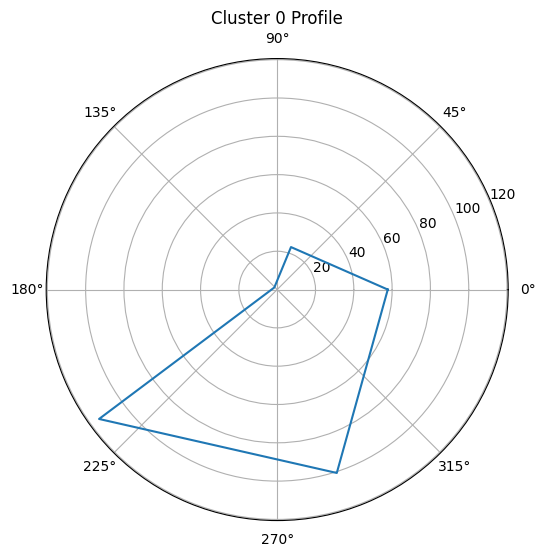

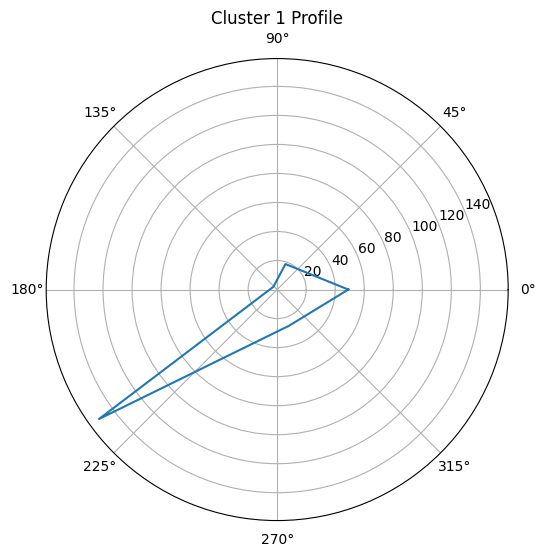

In [70]:
num_vars = ["age","bmi","asa","preop_gluc","preop_pt"]

cluster_centers = df_cluster.groupby("cluster")[num_vars].mean()

for c in cluster_centers.index:
    vals = cluster_centers.loc[c].values
    angles = np.linspace(0, 2*np.pi, len(vals), endpoint=False)
    vals = np.concatenate((vals, [vals[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    plt.figure(figsize=(6,6))
    plt.polar(angles, vals)
    plt.title(f"Cluster {c} Profile")
    plt.show()

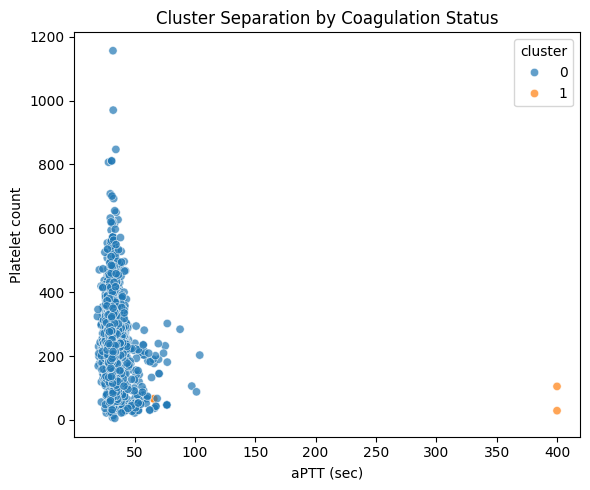

In [71]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_cluster,
    x="preop_aptt",
    y="preop_plt",
    hue="cluster",
    alpha=0.7
)
plt.xlabel("aPTT (sec)")
plt.ylabel("Platelet count")
plt.title("Cluster Separation by Coagulation Status")
plt.tight_layout()
plt.show()

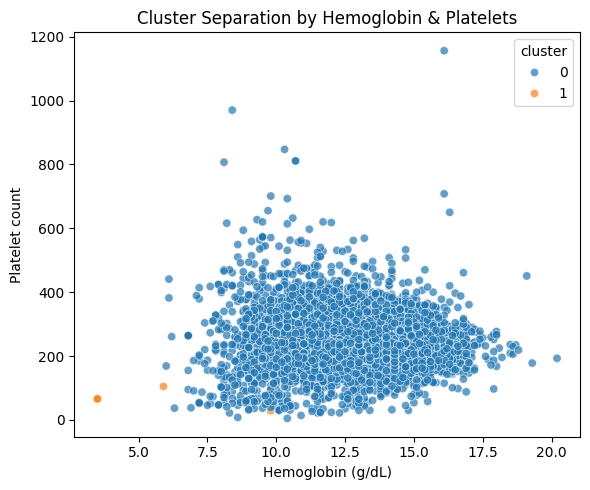

In [72]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_cluster,
    x="preop_hb",
    y="preop_plt",
    hue="cluster",
    alpha=0.7
)
plt.xlabel("Hemoglobin (g/dL)")
plt.ylabel("Platelet count")
plt.title("Cluster Separation by Hemoglobin & Platelets")
plt.tight_layout()
plt.show()


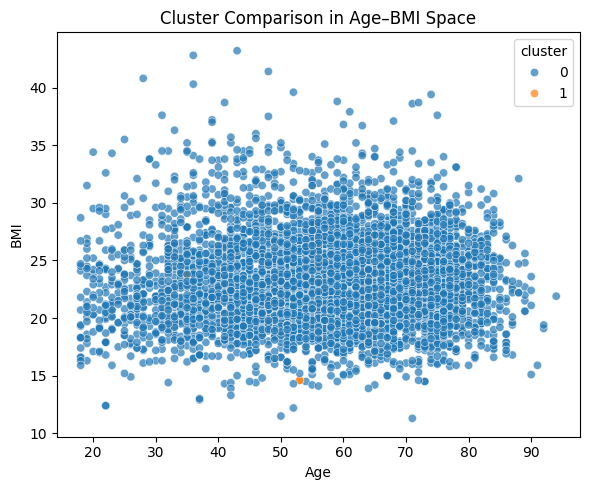

In [73]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_cluster,
    x="age",
    y="bmi",
    hue="cluster",
    alpha=0.7
)
plt.xlabel("Age")
plt.ylabel("BMI")
plt.title("Cluster Comparison in Age–BMI Space")
plt.tight_layout()
plt.show()


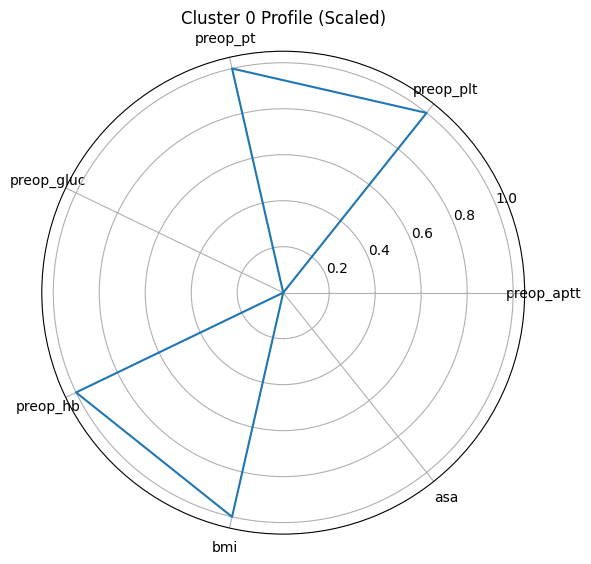

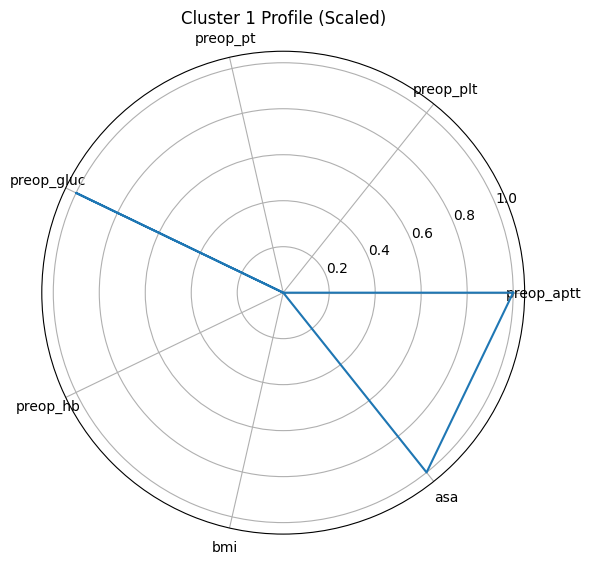

In [ ]:
num_vars = ["preop_aptt","preop_plt","preop_pt","preop_gluc","preop_hb","bmi","asa"]

cluster_centers = df_cluster.groupby("cluster")[num_vars].mean()

scaler = MinMaxScaler()
centers_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_centers),
    columns=num_vars,
    index=cluster_centers.index
)

for c in centers_scaled.index:
    vals = centers_scaled.loc[c].values
    angles = np.linspace(0, 2*np.pi, len(vals), endpoint=False)
    vals = np.concatenate((vals, [vals[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    plt.figure(figsize=(6,6))
    plt.polar(angles, vals)
    plt.title(f"Cluster {c} Profile (Scaled)")
    plt.xticks(angles[:-1], num_vars)
    plt.tight_layout()
    plt.show()


# U-map embedding + K-means Cluster

### UMAP Embedding (2D + 3D)

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ---- (1) Numeric / Categorical 분리 ----
num_cols = df_cluster.select_dtypes(include=['float64','int64']).columns
cat_cols = df_cluster.select_dtypes(include=['object']).columns

# ---- (2) Preprocess pipeline ----
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# ---- (3) 전체 feature 변환 ----
X_processed = preprocess.fit_transform(df_cluster)

print("X_processed shape:", X_processed.shape)


# ---- (4) UMAP 2D Embedding ----
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_processed)

# ---- (5) UMAP 3D Embedding ----
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_processed)


X_processed shape: (6331, 29)


/home/nakyung/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/nakyung/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 3) UMAP 기반 KMeans로 최적 k 찾기

In [ ]:
K_range = range(2, 10)

sil_scores = []
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap_2d)
    
    sil = silhouette_score(X_umap_2d, labels)
    sil_scores.append(sil)
    
    inertias.append(kmeans.inertia_)
    print(f"k={k}: Silhouette={sil:.4f}, Inertia={kmeans.inertia_:.0f}")

best_k = K_range[np.argmax(sil_scores)]
print("\nBest k (UMAP 2D 기준) =", best_k)


k=2: Silhouette=0.5259, Inertia=187450
k=3: Silhouette=0.6178, Inertia=88631
k=4: Silhouette=0.5845, Inertia=53343
k=5: Silhouette=0.6252, Inertia=37572
k=6: Silhouette=0.6791, Inertia=18412
k=7: Silhouette=0.6543, Inertia=15472
k=8: Silhouette=0.6729, Inertia=11003
k=9: Silhouette=0.6246, Inertia=9078

Best k (UMAP 2D 기준) = 6


### 4) Elbow Plot + Silhouette Plot 시각화

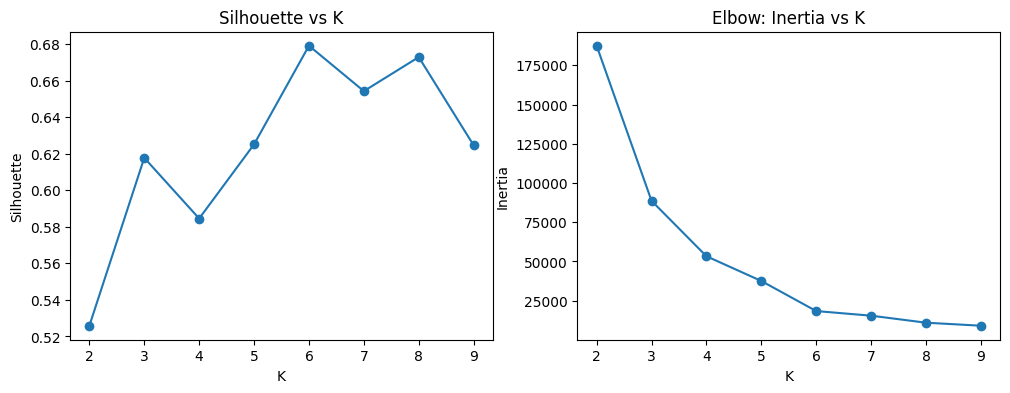

In [77]:
plt.figure(figsize=(12,4))

# Silhouette
plt.subplot(1,2,1)
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette vs K")
plt.xlabel("K")
plt.ylabel("Silhouette")

# Elbow
plt.subplot(1,2,2)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow: Inertia vs K")
plt.xlabel("K")
plt.ylabel("Inertia")

plt.show()


### 5) 최종 KMeans로 cluster 생성 + 시각화

In [78]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_umap_2d)

df_cluster["cluster_umap"] = cluster_labels

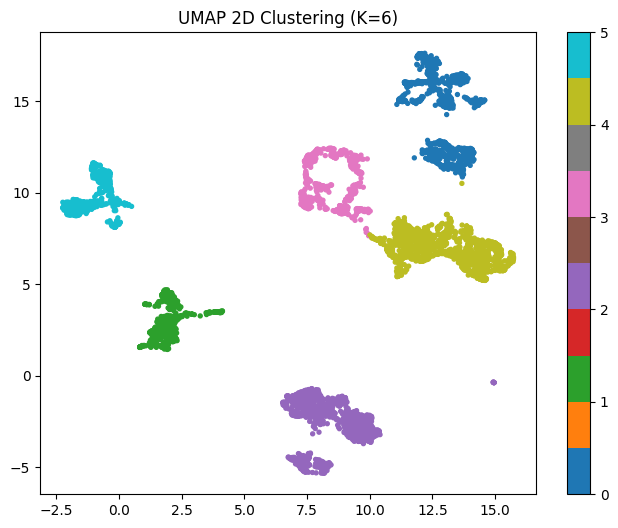

In [79]:
# 2D Plot
plt.figure(figsize=(8,6))
plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], 
            c=cluster_labels, cmap='tab10', s=8)
plt.title(f"UMAP 2D Clustering (K={best_k})")
plt.colorbar()
plt.show()


## 6) 클러스터별 임상 특성 해석

In [80]:
print("\n=== Cluster별 HTN 비율 ===")
print(df_cluster.groupby("cluster_umap")["preop_htn"].mean())

cluster_col = "cluster_umap"   
# 1) numeric columns only
numeric_cols = df_cluster.select_dtypes(include=[np.number]).columns.tolist()

# cluster label itself should not be averaged as a feature
numeric_feature_cols = [c for c in numeric_cols if c != cluster_col]

# 2) cluster-wise mean table
#    shape: (n_clusters, n_features)
cluster_means = df_cluster.groupby(cluster_col)[numeric_feature_cols].mean()

# 3) make features as rows so we can sort by variance across clusters
#    shape: (n_features, n_clusters)
feat_by_cluster = cluster_means.T  # index=feature, columns=cluster labels

# 4) variance across clusters for each feature
feat_by_cluster["var_across_clusters"] = feat_by_cluster.var(axis=1)

# 5) sort features by variance (descending)
feat_sorted = feat_by_cluster.sort_values("var_across_clusters", ascending=False)

print("\n=== Feature means per cluster (sorted by variance across clusters) ===")
print(feat_sorted)


=== Cluster별 HTN 비율 ===
cluster_umap
0    0.000000
1    0.323319
2    0.992160
3    0.000000
4    0.002651
5    0.505170
Name: preop_htn, dtype: float64

=== Feature means per cluster (sorted by variance across clusters) ===
cluster_umap           0           1           2           3           4  \
preop_gluc    101.979920  116.047210  115.265146  106.864662  108.355202   
preop_plt     257.802410  233.866953  236.801853  242.704261  238.510272   
age            49.926104   56.366237   64.938703   54.568922   56.642147   
preop_pt      101.770281   93.600858  103.352815  101.714286   99.138502   
preop_aptt     32.866506   35.649213   32.067213   32.154386   32.560769   
bmi            23.111406   22.411302   24.327655   23.140977   22.873095   
preop_hb       13.461124   12.039914   12.911547   13.148747   12.686349   
asa             1.000000    2.125894    2.110478    1.685464    2.096090   
preop_htn       0.000000    0.323319    0.992160    0.000000    0.002651   
preop_dm      

# Cluster별 SHAP 비교

### 1. Test set + cluster label 매칭

In [81]:
# Test set에 cluster label 추가 
df_test = df_cluster.loc[X_test.index].copy()
test_clusters = df_test["cluster_umap"].values

unique_clusters = sorted(df_test["cluster_umap"].unique())
print("클러스터 목록:", unique_clusters)

클러스터 목록: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]


### 2. cluster별 SHAP 계산 함수

In [82]:
os.makedirs("shap_cluster_plots", exist_ok=True)

def compute_and_plot_shap_for_cluster(c):
    print(f"\n=== Cluster {c} SHAP 분석 시작 ===")

    idx = np.where(test_clusters == c)[0]
    X_test_c = X_test.iloc[idx]

    if len(X_test_c) < 20:
        print(f"Cluster {c} 데이터 {len(X_test_c)}개 → 너무 적어서 SKIP")
        return None

    # Transform
    X_test_c_trans = preprocessor.transform(X_test_c)

    # Explainer
    explainer = shap.TreeExplainer(best_pipe.named_steps["clf"])
    shap_values_c = explainer.shap_values(X_test_c_trans)

    # Summary (beeswarm)
    plt.figure(figsize=(8,6))
    shap.summary_plot(
        shap_values_c,
        X_test_c_trans,
        feature_names=all_feature_names,
        show=False
    )
    plt.title(f"Cluster {c} SHAP Summary")
    plt.tight_layout()
    plt.savefig(f"shap_cluster_plots/cluster_{c}_summary.png", dpi=140)
    plt.close()

    # Bar plot
    plt.figure(figsize=(8,6))
    shap.summary_plot(
        shap_values_c,
        X_test_c_trans,
        feature_names=all_feature_names,
        plot_type="bar",
        show=False
    )
    plt.title(f"Cluster {c} SHAP Importance (Bar)")
    plt.tight_layout()
    plt.savefig(f"shap_cluster_plots/cluster_{c}_bar.png", dpi=140)
    plt.close()

    # mean |shap| return for table
    mean_abs = np.abs(shap_values_c).mean(axis=0)
    return mean_abs


### 3. 모든 클러스터 자동 SHAP 분석 + 비교 테이블 생성

In [83]:
cluster_importances = {}

for c in unique_clusters:
    imp = compute_and_plot_shap_for_cluster(c)
    if imp is not None:
        cluster_importances[c] = imp

# 비교용 DataFrame 생성
import pandas as pd

importance_df = pd.DataFrame(cluster_importances, index=all_feature_names)
importance_df.columns = [f"Cluster_{c}" for c in importance_df.columns]

print("\n=== Cluster별 mean(|SHAP|) 비교 ===")
importance_df_sorted = importance_df.sort_values("Cluster_0", ascending=False)
importance_df_sorted.head(20)



=== Cluster 0 SHAP 분석 시작 ===



=== Cluster 1 SHAP 분석 시작 ===

=== Cluster 2 SHAP 분석 시작 ===

=== Cluster 3 SHAP 분석 시작 ===

=== Cluster 4 SHAP 분석 시작 ===

=== Cluster 5 SHAP 분석 시작 ===

=== Cluster별 mean(|SHAP|) 비교 ===


Cluster_0  Cluster_1  Cluster_2  Cluster_3  \
asa                          1.456851   0.821746   0.624016   0.778277   
age                          0.546123   0.773489   0.608237   0.662981   
bmi                          0.270825   0.372611   0.314670   0.290133   
preop_pt                     0.142500   0.216551   0.172823   0.150143   
preop_gluc                   0.119359   0.117659   0.110816   0.066467   
preop_hb                     0.086185   0.079191   0.060209   0.060382   
preop_plt                    0.081967   0.147893   0.141773   0.078073   
optype_Transplantation       0.063540   0.068094   0.053183   0.028320   
preop_aptt                   0.061536   0.085346   0.072164   0.044702   
preop_k                      0.058425   0.075685   0.078204   0.053511   
department_General surgery   0.044518   0.083778   0.069549   0.150520   
preop_na                     0.039767   0.050431   0.053294   0.027938   
optype_Biliary/Pancreas      0.037126   0.012574   0.008216   0.009629   
optype_Stomach               0.032856   0.025635   0.033974   0.017396   
optype_Others                0.028743   0.051465   0.028702   0.039576   
sex_F                        0.014200   0.025044   0.017682   0.014898   
preop_dm_0                   0.010957   0.010305   0.008068   0.008300   
optype_Minor resection       0.009687   0.013353   0.018307   0.045006   
preop_dm_1                   0.007942   0.007667   0.006193   0.006149   
emop_0                       0.006432   0.036123   0.005456   0.002147   

                            Cluster_4  Cluster_5  
asa                          0.523769   0.578140  
age                          0.658415   0.524767  
bmi                          0.352223   0.354200  
preop_pt                     0.165589   0.148805  
preop_gluc                   0.113959   0.118136  
preop_hb                     0.058825   0.057044  
preop_plt                    0.127157   0.160951  
optype_Transplantation       0.040753   0.033094  
preop_aptt                   0.058922   0.063772  
preop_k                      0.066068   0.062114  
department_General surgery   0.050222   0.071476  
preop_na                     0.029123   0.043570  
optype_Biliary/Pancreas      0.007005   0.010122  
optype_Stomach               0.031882   0.032838  
optype_Others                0.034618   0.024487  
sex_F                        0.017217   0.019448  
preop_dm_0                   0.008596   0.137604  
optype_Minor resection       0.009921   0.019649  
preop_dm_1                   0.006272   0.090878  
emop_0                       0.006707   0.007531

### 결과 해석 가이드

In [84]:
for f in importance_df_sorted.head(10).index:
    vals = importance_df.loc[f]
    max_c = vals.idxmax()
    print(f"- Feature '{f}'은(는) {max_c}에서 영향력이 가장 높음 (mean|SHAP|={vals.max():.4f})")


- Feature 'asa'은(는) Cluster_0에서 영향력이 가장 높음 (mean|SHAP|=1.4569)
- Feature 'age'은(는) Cluster_1에서 영향력이 가장 높음 (mean|SHAP|=0.7735)
- Feature 'bmi'은(는) Cluster_1에서 영향력이 가장 높음 (mean|SHAP|=0.3726)
- Feature 'preop_pt'은(는) Cluster_1에서 영향력이 가장 높음 (mean|SHAP|=0.2166)
- Feature 'preop_gluc'은(는) Cluster_0에서 영향력이 가장 높음 (mean|SHAP|=0.1194)
- Feature 'preop_hb'은(는) Cluster_0에서 영향력이 가장 높음 (mean|SHAP|=0.0862)
- Feature 'preop_plt'은(는) Cluster_5에서 영향력이 가장 높음 (mean|SHAP|=0.1610)
- Feature 'optype_Transplantation'은(는) Cluster_1에서 영향력이 가장 높음 (mean|SHAP|=0.0681)
- Feature 'preop_aptt'은(는) Cluster_1에서 영향력이 가장 높음 (mean|SHAP|=0.0853)
- Feature 'preop_k'은(는) Cluster_2에서 영향력이 가장 높음 (mean|SHAP|=0.0782)


# Cluser SHAP Heatmap

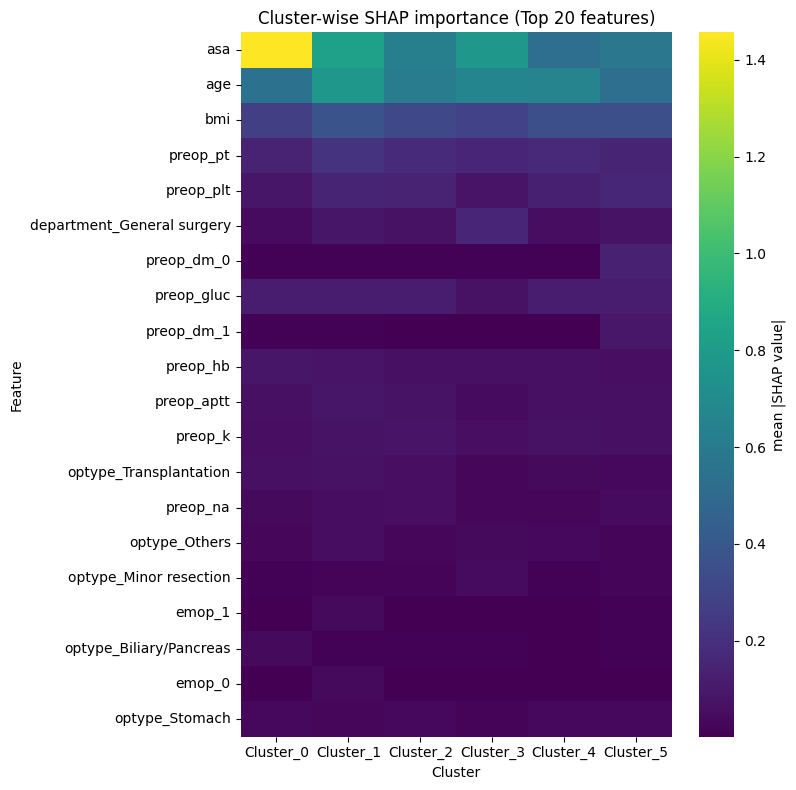

In [ ]:
# 1) 각 feature에 대해 max 중요도가 높은 순으로 정렬
importance_df_sorted = importance_df.copy()
importance_df_sorted["max_importance"] = importance_df_sorted.max(axis=1)
importance_df_sorted = importance_df_sorted.sort_values("max_importance", ascending=False)

# 2) 상위 N개 feature만 보기 
TOP_N = 20
top_imp = importance_df_sorted.head(TOP_N).drop(columns=["max_importance"])

plt.figure(figsize=(8, max(6, TOP_N * 0.4)))
sns.heatmap(
    top_imp,
    annot=False,
    cmap="viridis",
    cbar_kws={"label": "mean |SHAP value|"},
)
plt.title(f"Cluster-wise SHAP importance (Top {TOP_N} features)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


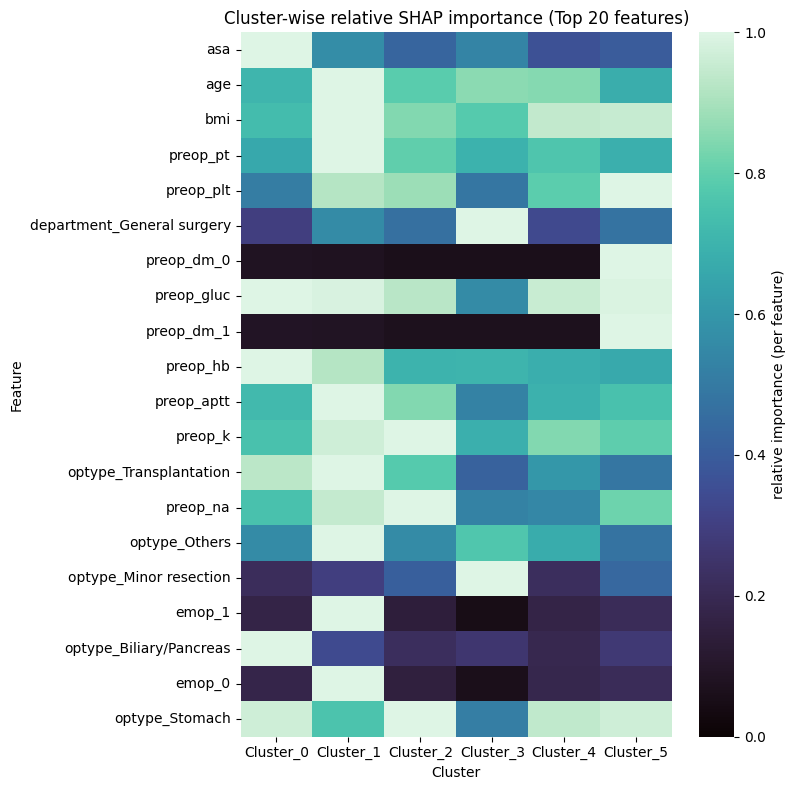

In [86]:
# Row-normalization: 각 feature별로 0~1 스케일로 클러스터 간 비교
top_imp_norm = top_imp.div(top_imp.max(axis=1), axis=0)

plt.figure(figsize=(8, max(6, TOP_N * 0.4)))
sns.heatmap(
    top_imp_norm,
    annot=False,
    cmap="mako",
    cbar_kws={"label": "relative importance (per feature)"},
    vmin=0,
    vmax=1,
)
plt.title(f"Cluster-wise relative SHAP importance (Top {TOP_N} features)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
